In [1]:
import pandas as pd

file_id = "1eiZkHD5L41lsbpbLXTA2BP7afOt9Z5Nw"
url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(url)


In [2]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)


## Phase 1: Data Exploration & Understanding

In [4]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [5]:
df.shape

(463291, 15)

In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   DateTime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

None

In [8]:
import pandas as pd

def load_data(path: str) -> pd.DataFrame:
    """
    Load dataset from a given path.
    """
    return pd.read_csv(path)


In [9]:
def get_dataset_dimensions(df: pd.DataFrame) -> dict:
    """
    Returns number of rows and columns.
    """
    rows, cols = df.shape
    return {
        "rows": rows,
        "columns": cols
    }


In [10]:
def detect_datetime_object_columns(
    df: pd.DataFrame,
    min_parse_ratio: float = 0.8,
    sample_size: int = 1000
) -> list:
    """
    Detects object columns that can be reliably parsed as datetime.
    """

    datetime_cols = []

    for col in df.select_dtypes(include=["object"]).columns:
        sample = df[col].dropna().head(sample_size)

        if sample.empty:
            continue

        parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
        parse_ratio = parsed.notna().mean()

        if parse_ratio >= min_parse_ratio:
            datetime_cols.append(col)

    return datetime_cols


In [11]:
def detect_epoch_columns(
    df: pd.DataFrame,
    sample_size: int = 1000
) -> list:
    """
    Detects numeric columns that look like UNIX epoch timestamps.
    """

    epoch_cols = []

    for col in df.select_dtypes(include=["number"]).columns:
        sample = df[col].dropna().head(sample_size)

        if sample.empty:
            continue

        # Heuristic: epoch seconds or milliseconds range
        if sample.between(1e9, 2e10).mean() > 0.8:
            epoch_cols.append(col)

    return epoch_cols


In [12]:
def classify_columns_ctr(
    df: pd.DataFrame
) -> dict:
    """
    CTR-aware column classification with robust datetime detection.
    """

    datetime_cols = set()

    # 1. Native datetime dtype
    datetime_cols.update(
        df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
    )

    # 2. Object columns parseable as datetime
    datetime_cols.update(detect_datetime_object_columns(df))

    # 3. Epoch timestamps (numeric)
    datetime_cols.update(detect_epoch_columns(df))

    numerical_cols = []
    categorical_cols = []

    for col in df.columns:
        if col in datetime_cols:
            continue

        if pd.api.types.is_numeric_dtype(df[col]):
            unique_ratio = df[col].nunique() / len(df)

            if unique_ratio < 0.05:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        else:
            categorical_cols.append(col)

    return {
        "numerical_features": numerical_cols,
        "categorical_features": categorical_cols,
        "datetime_features": sorted(datetime_cols)
    }


In [13]:
# def analyze_target(df: pd.DataFrame, target_col: str) -> dict:
#     """
#     Analyzes binary CTR target safely, even if stored as category/bool.
#     """

#     if target_col not in df.columns:
#         raise ValueError(f"{target_col} not found in dataframe")

#     target_series = df[target_col]

#     # Explicit numeric view for CTR computation
#     target_numeric = target_series.astype("int8")

#     return {
#         "target_column": target_col,
#         "dtype": str(target_series.dtype),
#         "unique_values": target_series.unique().tolist(),
#         "value_counts": target_series.value_counts(normalize=True).to_dict(),
#         "mean_ctr": target_numeric.mean()
#     }
def analyze_target(df: pd.DataFrame, target_col: str) -> dict:
    """
    Analyzes binary CTR target safely, even if stored as category/bool.
    """

    if target_col not in df.columns:
        raise ValueError(f"{target_col} not found in dataframe")

    target_series = df[target_col]
    target_numeric = target_series.astype("int8")

    return {
        "target_column": target_col,
        "dtype": str(target_series.dtype),
        "unique_values": target_series.unique().tolist(),
        "value_counts": target_series.value_counts(normalize=True).to_dict(),
        "mean_ctr": target_numeric.mean()
    }


In [14]:
# def missing_values_summary(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Returns count and percentage of missing values per column.
#     """
#     missing_count = df.isna().sum()
#     missing_pct = (missing_count / len(df)) * 100

#     summary = pd.DataFrame({
#         "missing_count": missing_count,
#         "missing_percentage": missing_pct
#     })

#     return summary[summary["missing_count"] > 0].sort_values(
#         by="missing_percentage", ascending=False
#     )
def missing_values_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns count and percentage of missing values per column.
    """
    missing_count = df.isna().sum()
    missing_pct = (missing_count / len(df)) * 100

    summary = pd.DataFrame({
        "missing_count": missing_count,
        "missing_percentage": missing_pct
    })

    return summary[summary["missing_count"] > 0].sort_values(
        by="missing_percentage", ascending=False
    )


In [15]:
# def run_phase1_eda(df: pd.DataFrame, target_col: str) -> dict:
#     """
#     Runs all Phase-1 checks and returns results in a structured form.
#     """
#     column_classification = classify_columns_ctr(df)
#     return {
#         "dimensions": get_dataset_dimensions(df),
#         "column_classification": column_classification,
#         "target_analysis": analyze_target(df, target_col),
#         "missing_values": missing_values_summary(df)
#     }
from typing import Optional, Dict
import pandas as pd

def run_phase1_eda(df: pd.DataFrame, target_col: Optional[str] = None) -> Dict:
    """
    Runs Phase-1 EDA.
    Works for both training data (with target)
    and test data (without target).
    """

    results = {
        "dimensions": get_dataset_dimensions(df),
        "column_classification": classify_columns_ctr(df),
        "missing_values": missing_values_summary(df)
    }

    # Run target analysis ONLY if target exists
    if target_col is not None and target_col in df.columns:
        results["target_analysis"] = analyze_target(df, target_col)
    else:
        results["target_analysis"] = None

    return results


In [16]:
file_id = "1eiZkHD5L41lsbpbLXTA2BP7afOt9Z5Nw"
url = f"https://drive.google.com/uc?id={file_id}"
df = load_data(url)


In [17]:
eda_results = run_phase1_eda(df, target_col="is_click")

C:\Users\EGE1\AppData\Local\Temp\ipykernel_18380\3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
C:\Users\EGE1\AppData\Local\Temp\ipykernel_18380\3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
C:\Users\EGE1\AppData\Local\Temp\ipykernel_18380\3051496443.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To en

In [314]:
eda_results["dimensions"]

{'rows': 463291, 'columns': 15}

In [19]:
column_info = eda_results["column_classification"]
column_info

{'numerical_features': ['session_id', 'user_id'],
 'categorical_features': ['product',
  'campaign_id',
  'webpage_id',
  'product_category_1',
  'product_category_2',
  'user_group_id',
  'gender',
  'age_level',
  'user_depth',
  'city_development_index',
  'var_1',
  'is_click'],
 'datetime_features': ['DateTime']}

In [20]:
eda_results["target_analysis"]

{'target_column': 'is_click',
 'dtype': 'int64',
 'unique_values': [0, 1],
 'value_counts': {0: 0.9323729578170091, 1: 0.06762704218299082},
 'mean_ctr': np.float64(0.06762704218299082)}

In [21]:
eda_results["missing_values"]

,missing_count,missing_percentage
product_category_2,365854,78.968510
city_development_index,125129,27.008727
user_group_id,18243,3.937698
gender,18243,3.937698
age_level,18243,3.937698
user_depth,18243,3.937698


In [22]:
df[df['gender'].isna()].head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
8,390699,2017-07-02 00:02,611906,H,105960,11085,5,270915.0,NaN,NaN,NaN,NaN,NaN,0,0
104,494858,2017-07-02 00:12,51597,H,359520,13787,3,NaN,NaN,NaN,NaN,NaN,NaN,0,0
119,103188,2017-07-02 00:14,172910,C,405490,60305,3,NaN,NaN,NaN,NaN,NaN,NaN,0,1
133,428248,2017-07-02 00:16,172910,H,404347,53587,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
136,4971,2017-07-02 00:17,172910,I,404347,53587,1,146115.0,NaN,NaN,NaN,NaN,NaN,0,0


#### Step-by-step: impose column classification on the DataFrame

In [23]:
eda_results = run_phase1_eda(df, target_col="is_click")

col_info = eda_results["column_classification"]

datetime_cols = col_info["datetime_features"]
categorical_cols = col_info["categorical_features"]
numerical_cols = col_info["numerical_features"]


C:\Users\EGE1\AppData\Local\Temp\ipykernel_18380\3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
C:\Users\EGE1\AppData\Local\Temp\ipykernel_18380\3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
C:\Users\EGE1\AppData\Local\Temp\ipykernel_18380\3051496443.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To en

In [24]:
def impose_datetime_columns(df: pd.DataFrame, datetime_cols: list) -> pd.DataFrame:
    """
    Converts detected datetime columns safely.
    Handles:
    - string timestamps
    - epoch seconds
    - epoch milliseconds
    """

    for col in datetime_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Epoch heuristic
            median_val = df[col].dropna().median()

            if median_val > 1e12:  # milliseconds
                df[col] = pd.to_datetime(df[col], unit="ms", errors="coerce")
            else:  # seconds
                df[col] = pd.to_datetime(df[col], unit="s", errors="coerce")
        else:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    return df


In [25]:
df = impose_datetime_columns(df, datetime_cols)


In [26]:
def impose_categorical_columns(df: pd.DataFrame, categorical_cols: list) -> pd.DataFrame:
    """
    Forces categorical semantics explicitly.
    """
    for col in categorical_cols:
        df[col] = df[col].astype("category")
    return df


In [27]:
df = impose_categorical_columns(df, categorical_cols)


In [324]:
df.dtypes


,0
session_id,int64
DateTime,datetime64[ns]
user_id,int64
product,category
campaign_id,category
webpage_id,category
product_category_1,category
product_category_2,category
user_group_id,category
gender,category


## Phase 2: Feature Engineering

#### Define time-of-day buckets (explicit & interpretable)

In [325]:
def map_time_of_day(hour: int) -> str:
    """
    Maps hour of day to time-of-day bucket.
    """
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "evening"

#### Core DateTime feature extraction function

In [326]:
def extract_datetime_features(
    df: pd.DataFrame,
    datetime_col: str,
    drop_original: bool = False
) -> pd.DataFrame:
    """
    Extracts CTR-relevant datetime features from a single datetime column.
    """

    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        raise ValueError(f"{datetime_col} must be datetime64 dtype")


    df[f"hour"] = df[datetime_col].dt.hour
    df[f"day_of_week"] = df[datetime_col].dt.dayofweek
    df[f"day_of_month"] = df[datetime_col].dt.day
    df[f"month"] = df[datetime_col].dt.month

    df[f"is_weekend"] = (
        df[datetime_col].dt.dayofweek >= 5
    ).astype("int8")

    df[f"time_of_day"] = (
        df[f"hour"]
        .apply(map_time_of_day)
        .astype("category")
    )

    if drop_original:
        df = df.drop(columns=[datetime_col])

    return df

In [327]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


#### Apply to all datetime columns (clean orchestration)

In [328]:
def engineer_datetime_features(
    df: pd.DataFrame,
    datetime_cols: list,
    drop_original: bool = False
) -> pd.DataFrame:
    """
    Applies datetime feature extraction to all datetime columns.
    """

    for col in datetime_cols:
        df = extract_datetime_features(
            df,
            datetime_col=col
        )

    return df

In [329]:
eda_results

{'dimensions': {'rows': 463291, 'columns': 15},
 'column_classification': {'numerical_features': ['session_id', 'user_id'],
  'categorical_features': ['product',
   'campaign_id',
   'webpage_id',
   'product_category_1',
   'product_category_2',
   'user_group_id',
   'gender',
   'age_level',
   'user_depth',
   'city_development_index',
   'var_1',
   'is_click'],
  'datetime_features': ['DateTime']},
 'missing_values':                         missing_count  missing_percentage
 product_category_2             365854           78.968510
 city_development_index         125129           27.008727
 user_group_id                   18243            3.937698
 gender                          18243            3.937698
 age_level                       18243            3.937698
 user_depth                      18243            3.937698,
 'target_analysis': {'target_column': 'is_click',
  'dtype': 'int64',
  'unique_values': [0, 1],
  'value_counts': {0: 0.9323729578170091, 1: 0.0676270421829908

In [330]:
eda_results = run_phase1_eda(df, target_col="is_click")

In [331]:
datetime_cols = eda_results["column_classification"]["datetime_features"]

df = engineer_datetime_features(
    df,
    datetime_cols=datetime_cols,
    drop_original=True  # usually YES for ML models
)

In [332]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0,0,6,2,7,1,night
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0,0,6,2,7,1,night
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0,0,6,2,7,1,night


In [333]:
df.time_of_day.value_counts()

,count
time_of_day,
morning,153680
afternoon,144126
evening,129557
night,35928


#### Interaction Feature Engineering (CTR-grade)

In [334]:
def create_interaction_feature(
    df: pd.DataFrame,
    col_a: str,
    col_b: str,
    new_col_name: str,
    sep: str = "_"
) -> pd.DataFrame:
    """
    Creates a categorical interaction feature between two columns.
    """

    df[new_col_name] = (
        df[col_a].astype(str)
        + sep
        + df[col_b].astype(str)
    ).astype("category")

    return df


##### a) user × product

In [335]:
df = create_interaction_feature(
    df,
    col_a="user_id",
    col_b="product",
    new_col_name="user_product_interaction"
)


##### b) campaign × webpage

In [336]:
df = create_interaction_feature(
    df,
    col_a="campaign_id",
    col_b="webpage_id",
    new_col_name="campaign_webpage"
)

##### c) gender × age_level

In [337]:
df = create_interaction_feature(
    df,
    col_a="gender",
    col_b="age_level",
    new_col_name="gender_age"
)

In [338]:
def engineer_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Engineers CTR-relevant interaction features.
    """

    df = create_interaction_feature(
        df, "user_id", "product_category_1", "user_product_interaction"
    )

    df = create_interaction_feature(
        df, "campaign_id", "webpage_id", "campaign_webpage"
    )

    df = create_interaction_feature(
        df, "gender", "age_level", "gender_age"
    )

    return df


In [339]:
df = engineer_interaction_features(df)

#### interaction_cardinality_report

In [340]:
def interaction_cardinality_report(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    return pd.DataFrame({
        "feature": cols,
        "unique_values": [df[c].nunique() for c in cols]
    }).sort_values(by="unique_values", ascending=False)

interaction_cols = [
    "user_product_interaction",
    "campaign_webpage",
    "gender_age"
]

interaction_cardinality_report(df, interaction_cols)


,feature,unique_values
0,user_product_interaction,245770
2,gender_age,15
1,campaign_webpage,10


In [341]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0,0,6,2,7,1,night,858557_4,359520_13787,Female_4.0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,105960_11085,Female_2.0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_4,359520_13787,Female_2.0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0,0,6,2,7,1,night,1097446_3,359520_13787,Male_3.0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0,0,6,2,7,1,night,663656_3,405490_60305,Male_2.0


#### User - Level Aggregations

In [342]:
# def add_user_aggregates(
#     df: pd.DataFrame,
#     user_col: str,
#     target_col: str,
#     time_col: str,
#     session_col: str
# ) -> pd.DataFrame:
#     """
#     Adds leakage-safe user-level historical aggregates.
#     """

#     # 1. Sort by time (absolute requirement)
#     df = df.sort_values(time_col)

#     # 2. Numeric view of target (DO NOT mutate original)
#     click = df[target_col].astype("int8")

#     # -------------------------------
#     # User total views (historical)
#     # -------------------------------
#     df["user_total_views"] = (
#         df.groupby(user_col)
#           .cumcount()
#     )

#     # -------------------------------
#     # User total clicks (historical)
#     # -------------------------------
#     df["user_total_clicks"] = (
#         click
#         .groupby(df[user_col])
#         .cumsum()
#         .groupby(df[user_col])
#         .shift(1)
#         .fillna(0)
#     )

#     # -------------------------------
#     # User CTR (smoothed)
#     # -------------------------------
#     df["user_ctr"] = (
#         df["user_total_clicks"] /
#         (df["user_total_views"] + 1)
#     )

#     # -------------------------------
#     # User unique sessions (historical)
#     # -------------------------------
#     def historical_unique_sessions(x):
#         seen = set()
#         out = []

#         for v in x.shift():
#             if pd.notna(v):
#                 seen.add(v)
#             out.append(len(seen))

#         return out

#     df["user_sessions"] = (
#         df.groupby(user_col)[session_col]
#           .apply(historical_unique_sessions)
#           .explode()
#           .astype("int32")
#           .values
#     )

#     return df


def add_user_aggregates(
    df: pd.DataFrame,
    user_col: str,
    target_col: str,
    session_col: str
) -> pd.DataFrame:
    """
    Adds global user-level aggregates (non-cumulative).
    """

    user_agg = (
        df
        .groupby(user_col)
        .agg(
            user_total_views=(user_col, "count"),
            user_total_clicks=(target_col, lambda x: x.astype("int8").sum()),
            user_sessions=(session_col, "nunique")
        )
        .reset_index()
    )

    user_agg["user_ctr"] = (
        user_agg["user_total_clicks"] /
        user_agg["user_total_views"]
    )

    df = df.merge(user_agg, on=user_col, how="left")

    return df



#### Product-level aggregations

In [343]:
# def add_product_aggregates(df, product_col, target_col, time_col):
#     df = df.sort_values(time_col)
#     click = df[target_col].astype("int8")

#     df["product_views"] = df.groupby(product_col).cumcount()

#     df["product_clicks"] = (
#         click.groupby(df[product_col])
#         .cumsum()
#         .groupby(df[product_col])
#         .shift(1)
#         .fillna(0)
#     )

#     df["product_ctr"] = df["product_clicks"] / (df["product_views"] + 1)
#     return df

def add_product_aggregates(
    df: pd.DataFrame,
    product_col: str,
    target_col: str
) -> pd.DataFrame:
    """
    Adds global product-level aggregates (non-cumulative).
    """

    product_agg = (
        df
        .groupby(product_col)
        .agg(
            product_views=(product_col, "count"),
            product_clicks=(target_col, lambda x: x.astype("int8").sum())
        )
        .reset_index()
    )

    product_agg["product_ctr"] = (
        product_agg["product_clicks"] /
        product_agg["product_views"]
    )

    df = df.merge(product_agg, on=product_col, how="left")

    return df


#### Campaign-level aggregation function

In [344]:
# def add_campaign_aggregates(df, campaign_col, target_col, time_col):
#     df = df.sort_values(time_col)
#     click = df[target_col].astype("int8")

#     df["campaign_views"] = df.groupby(campaign_col).cumcount()

#     df["campaign_clicks"] = (
#         click.groupby(df[campaign_col])
#         .cumsum()
#         .groupby(df[campaign_col])
#         .shift(1)
#         .fillna(0)
#     )

#     df["campaign_ctr"] = df["campaign_clicks"] / (df["campaign_views"] + 1)
#     return df

def add_campaign_aggregates(
    df: pd.DataFrame,
    campaign_col: str,
    target_col: str
) -> pd.DataFrame:
    """
    Adds global campaign-level aggregates (non-cumulative).
    """

    campaign_agg = (
        df
        .groupby(campaign_col)
        .agg(
            campaign_views=(campaign_col, "count"),
            campaign_clicks=(target_col, lambda x: x.astype("int8").sum())
        )
        .reset_index()
    )

    campaign_agg["campaign_ctr"] = (
        campaign_agg["campaign_clicks"] /
        campaign_agg["campaign_views"]
    )

    df = df.merge(campaign_agg, on=campaign_col, how="left")

    return df


In [345]:
def engineer_aggregated_features(
    df: pd.DataFrame,
    target_col: str
) -> pd.DataFrame:
    """
    Adds all historical aggregated CTR features.
    """

    df = add_user_aggregates(
        df,
        user_col="user_id",
        target_col=target_col,
        session_col="session_id"
    )

    df = add_product_aggregates(
        df,
        product_col="product",
        target_col=target_col
    )

    df = add_campaign_aggregates(
        df,
        campaign_col="campaign_id",
        target_col=target_col
    )

    return df


In [346]:
df = engineer_aggregated_features(
    df,
    target_col="is_click"
)


/tmp/ipython-input-604305620.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(product_col)
/tmp/ipython-input-131019323.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(campaign_col)


In [347]:
df_aggregated_features = df.copy()

In [348]:
df_aggregated_features.shape

(463291, 34)

In [349]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0,0,6,2,7,1,night,858557_4,359520_13787,Female_4.0,2,0,2,0.000000,163501,11306,0.069149,108155,6340,0.058620
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,105960_11085,Female_2.0,3,0,3,0.000000,163501,11306,0.069149,25781,1762,0.068345
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_4,359520_13787,Female_2.0,3,0,3,0.000000,163501,11306,0.069149,108155,6340,0.058620
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0,0,6,2,7,1,night,1097446_3,359520_13787,Male_3.0,18,0,18,0.000000,63711,4079,0.064023,108155,6340,0.058620
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0,0,6,2,7,1,night,663656_3,405490_60305,Male_2.0,11,2,11,0.181818,163501,11306,0.069149,95973,8763,0.091307


In [350]:
df[df['user_id'] == 243253]

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,105960_11085,Female_2.0,3,0,3,0.0,163501,11306,0.069149,25781,1762,0.068345
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_4,359520_13787,Female_2.0,3,0,3,0.0,163501,11306,0.069149,108155,6340,0.058620
13,21726,2017-07-02 00:02:00,243253,C,360936,13787,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,360936_13787,Female_2.0,3,0,3,0.0,163501,11306,0.069149,51888,2346,0.045213


In [351]:
df[df['user_id'] == 243253]

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,105960_11085,Female_2.0,3,0,3,0.0,163501,11306,0.069149,25781,1762,0.068345
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_4,359520_13787,Female_2.0,3,0,3,0.0,163501,11306,0.069149,108155,6340,0.058620
13,21726,2017-07-02 00:02:00,243253,C,360936,13787,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,360936_13787,Female_2.0,3,0,3,0.0,163501,11306,0.069149,51888,2346,0.045213


In [352]:
df[(df['product'] == 'C') & (df['DateTime'] <= '2017-07-02 00:04:00')].sort_values('DateTime')

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0,0,6,2,7,1,night,858557_4,359520_13787,Female_4.0,2,0,2,0.000000,163501,11306,0.069149,108155,6340,0.058620
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,105960_11085,Female_2.0,3,0,3,0.000000,163501,11306,0.069149,25781,1762,0.068345
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_4,359520_13787,Female_2.0,3,0,3,0.000000,163501,11306,0.069149,108155,6340,0.058620
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0,0,6,2,7,1,night,663656_3,405490_60305,Male_2.0,11,2,11,0.181818,163501,11306,0.069149,95973,8763,0.091307
7,461128,2017-07-02 00:01:00,469098,C,360936,13787,3,NaN,4.0,Male,4.0,3.0,4.0,0,0,0,6,2,7,1,night,469098_3,360936_13787,Male_4.0,1,0,1,0.000000,163501,11306,0.069149,51888,2346,0.045213
10,75282,2017-07-02 00:02:00,312475,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,4.0,1,0,0,6,2,7,1,night,312475_3,405490_60305,Male_2.0,15,0,15,0.000000,163501,11306,0.069149,95973,8763,0.091307
13,21726,2017-07-02 00:02:00,243253,C,360936,13787,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,6,2,7,1,night,243253_5,360936_13787,Female_2.0,3,0,3,0.000000,163501,11306,0.069149,51888,2346,0.045213
23,175422,2017-07-02 00:03:00,43157,C,359520,13787,4,NaN,1.0,Male,1.0,3.0,3.0,0,0,0,6,2,7,1,night,43157_4,359520_13787,Male_1.0,5,0,5,0.000000,163501,11306,0.069149,108155,6340,0.058620
18,453157,2017-07-02 00:03:00,901661,C,360936,13787,3,NaN,9.0,Female,3.0,3.0,3.0,0,0,0,6,2,7,1,night,901661_3,360936_13787,Female_3.0,12,0,12,0.000000,163501,11306,0.069149,51888,2346,0.045213
15,191223,2017-07-02 00:03:00,312475,C,359520,13787,4,NaN,2.0,Male,2.0,3.0,4.0,1,0,0,6,2,7,1,night,312475_4,359520_13787,Male_2.0,15,0,15,0.000000,163501,11306,0.069149,108155,6340,0.058620


In [353]:
df[(df['campaign_id'] == 405490) & (df['is_click'] == 1)][['campaign_views', 'campaign_clicks', 'campaign_ctr', 'DateTime']].sort_values('DateTime').tail(50)

,campaign_views,campaign_clicks,campaign_ctr,DateTime
457240,95973,8763,0.091307,2017-07-07 20:47:00
457281,95973,8763,0.091307,2017-07-07 20:48:00
457416,95973,8763,0.091307,2017-07-07 20:50:00
457419,95973,8763,0.091307,2017-07-07 20:51:00
457444,95973,8763,0.091307,2017-07-07 20:51:00
457463,95973,8763,0.091307,2017-07-07 20:51:00
457479,95973,8763,0.091307,2017-07-07 20:52:00
457568,95973,8763,0.091307,2017-07-07 20:53:00
457577,95973,8763,0.091307,2017-07-07 20:53:00
457616,95973,8763,0.091307,2017-07-07 20:54:00


In [354]:
df[df['user_id'] == 252158][['user_total_views', 'user_total_clicks', 'user_ctr', 'DateTime']].sort_values('DateTime')

,user_total_views,user_total_clicks,user_ctr,DateTime
65680,51,15,0.294118,2017-07-02 19:48:00
65682,51,15,0.294118,2017-07-02 19:48:00
65874,51,15,0.294118,2017-07-02 19:50:00
65875,51,15,0.294118,2017-07-02 19:50:00
66431,51,15,0.294118,2017-07-02 19:56:00
66432,51,15,0.294118,2017-07-02 19:56:00
66433,51,15,0.294118,2017-07-02 19:56:00
66775,51,15,0.294118,2017-07-02 20:00:00
66776,51,15,0.294118,2017-07-02 20:00:00
81283,51,15,0.294118,2017-07-03 04:17:00


In [355]:
df[(df['product'] == 'C') & (df['is_click'] == 1)].shape[0]

11306

In [356]:
df[(df['product'] == 'C') & (df['is_click'] == 1)].shape[0]/df[(df['product'] == 'C')].shape[0]

0.06914942416254335

##  Phase 3: Data Preprocessing

### Step 1: Handle Missing Values

#### Numerical imputation (median)

In [357]:
def impute_numerical_median(
    df: pd.DataFrame,
    numerical_cols: list
) -> pd.DataFrame:
    """
    Fills missing values in numerical columns using median.
    """
    for col in numerical_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
    return df

#### Categorical imputation (mode)

In [358]:
def impute_categorical_mode(
    df: pd.DataFrame,
    categorical_cols: list
) -> pd.DataFrame:
    """
    Fills missing values in categorical columns using mode.
    """
    for col in categorical_cols:
        if df[col].isna().any():
            mode_val = df[col].mode(dropna=True)
            if not mode_val.empty:
                df[col] = df[col].fillna(mode_val.iloc[0])
    return df

In [359]:
def handle_missing_values(
    df: pd.DataFrame,
    eda_results: dict
) -> pd.DataFrame:
    """
    Handles missing values based on CTR-aware schema.
    """

    col_info = eda_results["column_classification"]

    numerical_cols = col_info["numerical_features"]
    categorical_cols = col_info["categorical_features"]

    df = impute_numerical_median(df, numerical_cols)
    df = impute_categorical_mode(df, categorical_cols)

    return df

In [360]:
df = handle_missing_values(df, eda_results)

In [361]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,82527.0,10.0,Female,4.0,3.0,3.0,0,0,0,6,2,7,1,night,858557_4,359520_13787,Female_4.0,2,0,2,0.000000,163501,11306,0.069149,108155,6340,0.058620
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,82527.0,8.0,Female,2.0,2.0,2.0,0,0,0,6,2,7,1,night,243253_5,105960_11085,Female_2.0,3,0,3,0.000000,163501,11306,0.069149,25781,1762,0.068345
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,82527.0,8.0,Female,2.0,2.0,2.0,0,0,0,6,2,7,1,night,243253_4,359520_13787,Female_2.0,3,0,3,0.000000,163501,11306,0.069149,108155,6340,0.058620
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,82527.0,3.0,Male,3.0,3.0,2.0,1,0,0,6,2,7,1,night,1097446_3,359520_13787,Male_3.0,18,0,18,0.000000,63711,4079,0.064023,108155,6340,0.058620
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,82527.0,2.0,Male,2.0,3.0,2.0,1,0,0,6,2,7,1,night,663656_3,405490_60305,Male_2.0,11,2,11,0.181818,163501,11306,0.069149,95973,8763,0.091307


In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   session_id                463291 non-null  int64         
 1   DateTime                  463291 non-null  datetime64[ns]
 2   user_id                   463291 non-null  int64         
 3   product                   463291 non-null  category      
 4   campaign_id               463291 non-null  category      
 5   webpage_id                463291 non-null  category      
 6   product_category_1        463291 non-null  category      
 7   product_category_2        463291 non-null  category      
 8   user_group_id             463291 non-null  category      
 9   gender                    463291 non-null  category      
 10  age_level                 463291 non-null  category      
 11  user_depth                463291 non-null  category      
 12  ci

In [363]:
missing_values_summary(df)

,missing_count,missing_percentage


### Step 2: Encode Categorical Variables

#### Custom label encoder wrapper

In [364]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

class SafeLabelEncoder:
    """
    Label encoder that safely handles unseen values.
    """

    def __init__(self):
        self.encoder = LabelEncoder()
        self.fitted = False

    def fit(self, series: pd.Series):
        series = series.astype(str)
        self.encoder.fit(series)
        self.fitted = True
        return self

    def transform(self, series: pd.Series):
        if not self.fitted:
            raise RuntimeError("Encoder must be fitted first")

        series = series.astype(str)
        known_classes = set(self.encoder.classes_)

        # Replace unseen labels
        series = series.apply(
            lambda x: x if x in known_classes else "__UNKNOWN__"
        )

        # Add __UNKNOWN__ safely if needed
        if "__UNKNOWN__" not in known_classes:
            self.encoder.classes_ = np.append(
                self.encoder.classes_, "__UNKNOWN__"
            )

        return self.encoder.transform(series)

    def fit_transform(self, series: pd.Series):
        return self.fit(series).transform(series)


#### Apply label encoding to your columns

In [365]:
def label_encode_columns(
    df: pd.DataFrame,
    categorical_cols: list
) -> tuple[pd.DataFrame, dict]:
    """
    Label-encodes categorical columns.
    Returns transformed df and fitted encoders.
    """

    encoders = {}

    for col in categorical_cols:
        le = SafeLabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

    return df, encoders


#### Apply it on our selected columns

In [366]:
label_encode_cols = [
    "product",
    "campaign_id",
    "webpage_id",
    "product_category_1",
    "product_category_2",
    "gender",
    "user_group_id",
    "var_1",
    "user_product_interaction",
    "campaign_webpage",
    "gender_age"
]

df, label_encoders = label_encode_columns(df, label_encode_cols)


In [367]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
0,140690,2017-07-02 00:00:00,858557,2,2,1,3,27,2,0,4.0,3.0,3.0,0,0,0,6,2,7,1,night,215362,2,4,2,0,2,0.000000,163501,11306,0.069149,108155,6340,0.058620
1,333291,2017-07-02 00:00:00,243253,2,0,0,4,27,11,0,2.0,2.0,2.0,0,0,0,6,2,7,1,night,67042,0,2,3,0,3,0.000000,163501,11306,0.069149,25781,1762,0.068345
2,129781,2017-07-02 00:00:00,243253,2,2,1,3,27,11,0,2.0,2.0,2.0,0,0,0,6,2,7,1,night,67041,2,2,3,0,3,0.000000,163501,11306,0.069149,108155,6340,0.058620
3,464848,2017-07-02 00:00:00,1097446,8,2,1,2,27,6,1,3.0,3.0,2.0,1,0,0,6,2,7,1,night,22959,2,10,18,0,18,0.000000,63711,4079,0.064023,108155,6340,0.058620
4,90569,2017-07-02 00:01:00,663656,2,6,7,2,27,5,1,2.0,3.0,2.0,1,0,0,6,2,7,1,night,172065,6,9,11,2,11,0.181818,163501,11306,0.069149,95973,8763,0.091307


In [368]:
cardinality_report = pd.DataFrame({
    "unique_values": df[label_encode_cols].nunique(),
    "missing_values": df[label_encode_cols].isna().sum()
}).sort_values(by="unique_values", ascending=False)

cardinality_report


,unique_values,missing_values
user_product_interaction,245770,0
product_category_2,29,0
gender_age,15,0
user_group_id,13,0
campaign_webpage,10,0
product,10,0
campaign_id,10,0
webpage_id,9,0
product_category_1,5,0
gender,2,0


#### Step 3: Feature Selection


In [369]:
def drop_unused_columns(
    df: pd.DataFrame,
    drop_cols: list
) -> pd.DataFrame:
    """
    Drops columns that should not be used for modeling.
    Ignores columns not present in the dataframe.
    """
    return df.drop(columns=drop_cols, errors="ignore")


In [370]:
drop_cols = ["DateTime", "session_id", "user_id"]

df = drop_unused_columns(df, drop_cols)

df.shape

(463291, 31)

In [371]:
df.head()

,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
0,2,2,1,3,27,2,0,4.0,3.0,3.0,0,0,0,6,2,7,1,night,215362,2,4,2,0,2,0.000000,163501,11306,0.069149,108155,6340,0.058620
1,2,0,0,4,27,11,0,2.0,2.0,2.0,0,0,0,6,2,7,1,night,67042,0,2,3,0,3,0.000000,163501,11306,0.069149,25781,1762,0.068345
2,2,2,1,3,27,11,0,2.0,2.0,2.0,0,0,0,6,2,7,1,night,67041,2,2,3,0,3,0.000000,163501,11306,0.069149,108155,6340,0.058620
3,8,2,1,2,27,6,1,3.0,3.0,2.0,1,0,0,6,2,7,1,night,22959,2,10,18,0,18,0.000000,63711,4079,0.064023,108155,6340,0.058620
4,2,6,7,2,27,5,1,2.0,3.0,2.0,1,0,0,6,2,7,1,night,172065,6,9,11,2,11,0.181818,163501,11306,0.069149,95973,8763,0.091307


In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   product                   463291 non-null  int64   
 1   campaign_id               463291 non-null  int64   
 2   webpage_id                463291 non-null  int64   
 3   product_category_1        463291 non-null  int64   
 4   product_category_2        463291 non-null  int64   
 5   user_group_id             463291 non-null  int64   
 6   gender                    463291 non-null  int64   
 7   age_level                 463291 non-null  category
 8   user_depth                463291 non-null  category
 9   city_development_index    463291 non-null  category
 10  var_1                     463291 non-null  int64   
 11  is_click                  463291 non-null  category
 12  hour                      463291 non-null  int32   
 13  day_of_week               463

#### Re-impose schema

In [373]:
from sklearn.preprocessing import LabelEncoder

cat_cols = [
    "age_level",
    "user_depth",
    "city_development_index",
    "time_of_day"
]

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

df["is_click"] = df["is_click"].astype(int)
df.dtypes.value_counts()

,count
int64,23
int32,4
float64,3
int8,1


#### Step 4: Train-Test Split

In [374]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["is_click"],
    random_state=42
)

In [375]:
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["is_click"],
    random_state=42
)

In [376]:
train_df.shape, val_df.shape, test_df.shape

((324303, 31), (69494, 31), (69494, 31))

In [377]:
def ctr(series):
    return series.astype("int8").mean()

print("Overall CTR:", ctr(df["is_click"]))
print("Train CTR  :", ctr(train_df["is_click"]))
print("Valid CTR  :", ctr(val_df["is_click"]))
print("Test CTR   :", ctr(test_df["is_click"]))

Overall CTR: 0.06762704218299082
Train CTR  : 0.06762811321511056
Valid CTR  : 0.06763173799176907
Test CTR   : 0.06761734826028146


In [378]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324303 entries, 77985 to 136913
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product                   324303 non-null  int64  
 1   campaign_id               324303 non-null  int64  
 2   webpage_id                324303 non-null  int64  
 3   product_category_1        324303 non-null  int64  
 4   product_category_2        324303 non-null  int64  
 5   user_group_id             324303 non-null  int64  
 6   gender                    324303 non-null  int64  
 7   age_level                 324303 non-null  int64  
 8   user_depth                324303 non-null  int64  
 9   city_development_index    324303 non-null  int64  
 10  var_1                     324303 non-null  int64  
 11  is_click                  324303 non-null  int64  
 12  hour                      324303 non-null  int32  
 13  day_of_week               324303 non-null  in

#### Step 5: Feature Scaling

In [379]:
scale_cols = [
    # time-based
    "hour",
    "day_of_week",
    "day_of_month",
    "month",

    # user aggregates
    "user_total_views",
    "user_total_clicks",
    "user_sessions",
    "user_ctr",

    # product aggregates
    "product_views",
    "product_clicks",
    "product_ctr",

    # campaign aggregates
    "campaign_views",
    "campaign_clicks",
    "campaign_ctr"
]


In [380]:
from sklearn.preprocessing import StandardScaler

def scale_features(train_df, val_df, test_df, scale_cols):
    scaler = StandardScaler()

    train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
    val_df[scale_cols]   = scaler.transform(val_df[scale_cols])
    test_df[scale_cols]  = scaler.transform(test_df[scale_cols])

    return train_df, val_df, test_df, scaler


In [381]:
train_df, val_df, test_df, scaler = scale_features(
    train_df,
    val_df,
    test_df,
    scale_cols
)

In [382]:
train_df[scale_cols].describe().loc[["mean", "std"]]

,hour,day_of_week,day_of_month,month,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
mean,-1.366517e-16,5.210160e-17,-1.317220e-16,0.0,-2.458284e-17,-3.400407e-17,-2.458284e-17,1.121784e-17,1.278658e-16,-4.355677e-17,2.044583e-15,-7.274067e-17,-1.352440e-16,-4.256206e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,0.0,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00


## Try model to check if SMOTE helps

In [383]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.linear_model import LogisticRegression

X_train = train_df.drop(columns=["is_click"])
y_train = train_df["is_click"].astype(int)

X_val = val_df.drop(columns=["is_click"])
y_val = val_df["is_click"].astype(int)

In [384]:
val_df.head()

,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr
284903,2,6,7,2,27,2,0,4,2,0,0,0,0.719394,-0.327713,0.319925,0.0,0,0,182116,6,4,-0.574127,-0.509612,-0.574127,-0.422488,1.136464,1.130757,0.233863,0.910826,1.533117,1.571371
56147,2,2,1,3,27,8,1,5,2,1,0,1,0.719394,1.684475,-1.446069,0.0,1,0,159940,2,12,-0.371912,0.371239,-0.371912,0.825413,1.136464,1.130757,0.233863,1.261884,0.671127,-0.598507
214110,4,5,6,0,1,1,1,1,2,3,0,0,1.094415,-0.830760,-0.268739,0.0,0,1,25337,5,8,-0.523573,-0.509612,-0.523573,-0.422488,-1.367713,-1.342058,0.166262,-1.024198,-0.789241,0.657097
65135,4,9,8,1,27,6,1,3,1,1,0,0,1.094415,1.684475,-1.446069,0.0,1,1,210736,9,10,-0.473020,-0.509612,-0.473020,-0.422488,-1.367713,-1.342058,0.166262,-0.844404,-0.625950,0.610269
309323,2,3,1,4,27,2,0,4,2,1,0,0,1.469435,-0.327713,0.319925,0.0,0,1,37513,3,4,-0.321358,0.371239,-0.321358,0.617429,1.136464,1.130757,0.233863,-0.359604,-0.749752,-1.488488


### No weight model

In [385]:
lr_plain = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

lr_plain.fit(X_train, y_train)

val_pred_plain = lr_plain.predict_proba(X_val)[:, 1]


In [386]:
print("Plain Logistic Regression")
print("AUC      :", roc_auc_score(y_val, val_pred_plain))
print("PR-AUC   :", average_precision_score(y_val, val_pred_plain))
print("LogLoss  :", log_loss(y_val, val_pred_plain))

Plain Logistic Regression
AUC      : 0.9421368720770704
PR-AUC   : 0.6363763865110167
LogLoss  : 0.1382843392286182


In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   product                   463291 non-null  int64  
 1   campaign_id               463291 non-null  int64  
 2   webpage_id                463291 non-null  int64  
 3   product_category_1        463291 non-null  int64  
 4   product_category_2        463291 non-null  int64  
 5   user_group_id             463291 non-null  int64  
 6   gender                    463291 non-null  int64  
 7   age_level                 463291 non-null  int64  
 8   user_depth                463291 non-null  int64  
 9   city_development_index    463291 non-null  int64  
 10  var_1                     463291 non-null  int64  
 11  is_click                  463291 non-null  int64  
 12  hour                      463291 non-null  int32  
 13  day_of_week               463291 non-null  i

#### SMOTE code (TRAIN DATA ONLY)

In [388]:
smote_features = [
    # time features
    "hour",
    "day_of_week",
    "day_of_month",
    "month",

    # user aggregates
    "user_total_views",
    "user_total_clicks",
    "user_sessions",
    "user_ctr",

    # product aggregates
    "product_views",
    "product_clicks",
    "product_ctr",

    # campaign aggregates
    "campaign_views",
    "campaign_clicks",
    "campaign_ctr"
]

In [389]:
X_train_smote_base = train_df[smote_features]
y_train = train_df["is_click"].astype(int)

In [390]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy=0.2,   # minority = 20% of majority
    k_neighbors=5,
    random_state=42
)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_smote_base,
    y_train
)

In [391]:
from sklearn.linear_model import LogisticRegression

lr_smote = LogisticRegression(
    max_iter=1000
)

lr_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000)

In [392]:
X_val = val_df[smote_features]
y_val = val_df["is_click"].astype(int)

val_pred_smote = lr_smote.predict_proba(X_val)[:, 1]

In [393]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

print("SMOTE Logistic Regression")
print("AUC     :", roc_auc_score(y_val, val_pred_smote))
print("PR-AUC  :", average_precision_score(y_val, val_pred_smote))
print("LogLoss :", log_loss(y_val, val_pred_smote))

SMOTE Logistic Regression
AUC     : 0.9493574070097114
PR-AUC  : 0.6439139702402077
LogLoss : 0.160031517382727


#### 50% rows - SMOTE

In [394]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy=0.5,   # minority = 50% of majority
    k_neighbors=5,
    random_state=42
)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_smote_base,
    y_train
)

In [395]:
from sklearn.linear_model import LogisticRegression

lr_smote = LogisticRegression(
    max_iter=1000
)

lr_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000)

In [396]:
X_val = val_df[smote_features]
y_val = val_df["is_click"].astype(int)

val_pred_smote = lr_smote.predict_proba(X_val)[:, 1]

from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

print("SMOTE Logistic Regression")
print("AUC     :", roc_auc_score(y_val, val_pred_smote))
print("PR-AUC  :", average_precision_score(y_val, val_pred_smote))
print("LogLoss :", log_loss(y_val, val_pred_smote))

SMOTE Logistic Regression
AUC     : 0.9490872086264883
PR-AUC  : 0.6410706524335631
LogLoss : 0.23872769875892574


In [397]:
# Features used by the model
X_val = val_df[smote_features]

# True labels
y_true = val_df["is_click"].astype(int)

# Predicted click probabilities
y_prob = lr_smote.predict_proba(X_val)[:, 1]

import numpy as np

THRESHOLD = 0.1  # tune this later

y_pred = (y_prob >= THRESHOLD).astype(int)


from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)

print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")


from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, digits=4))


Precision : 0.2210
Recall    : 0.9906
F1-score  : 0.3614
ROC-AUC   : 0.9491
              precision    recall  f1-score   support

           0     0.9991    0.7467    0.8547     64794
           1     0.2210    0.9906    0.3614      4700

    accuracy                         0.7632     69494
   macro avg     0.6101    0.8687    0.6080     69494
weighted avg     0.9465    0.7632    0.8213     69494



In [398]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_true, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")


ROC-AUC: 0.9491


In [399]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

for t in [0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]:
    y_pred_t = (y_prob >= t).astype(int)
    print(f"\nThreshold = {t}")
    print("Precision:", precision_score(y_true, y_pred_t))
    print("Recall   :", recall_score(y_true, y_pred_t))
    print("F1       :", f1_score(y_true, y_pred_t))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))



Threshold = 0.02
Precision: 0.06763173799176907
Recall   : 1.0
F1       : 0.12669488098768095
ROC-AUC: 0.9490872086264883

Threshold = 0.05
Precision: 0.09391922946266211
Recall   : 1.0
F1       : 0.17171145169245383
ROC-AUC: 0.9490872086264883

Threshold = 0.1
Precision: 0.2210196525206494
Recall   : 0.9906382978723405
F1       : 0.36140650469611113
ROC-AUC: 0.9490872086264883

Threshold = 0.15
Precision: 0.2540942090157015
Recall   : 0.9606382978723405
F1       : 0.4018870443722462
ROC-AUC: 0.9490872086264883

Threshold = 0.2
Precision: 0.28155276675986735
Recall   : 0.9212765957446809
F1       : 0.43129637930175807
ROC-AUC: 0.9490872086264883

Threshold = 0.3
Precision: 0.33446702613023643
Recall   : 0.857872340425532
F1       : 0.4812891674127126
ROC-AUC: 0.9490872086264883

Threshold = 0.4
Precision: 0.3760468166683483
Recall   : 0.7929787234042553
F1       : 0.510163575388406
ROC-AUC: 0.9490872086264883

Threshold = 0.5
Precision: 0.4194327097163549
Recall   : 0.7393617021276596

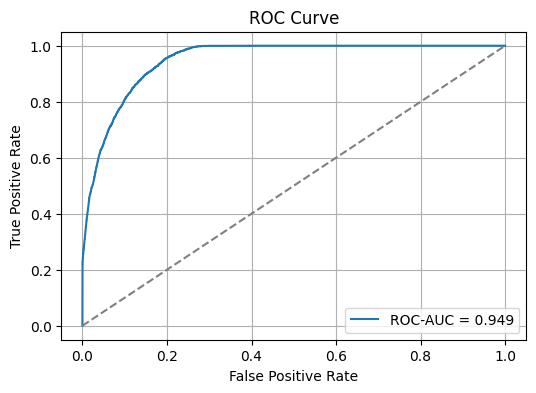

In [400]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [401]:
# Features (same columns used in training)
X_test = test_df[smote_features]

# True labels
y_test = test_df["is_click"].astype(int)


In [402]:
# Predicted click probabilities
y_test_prob = lr_smote.predict_proba(X_test)[:, 1]


In [403]:
THRESHOLD = 0.30

y_test_pred = (y_test_prob >= THRESHOLD).astype(int)


In [404]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Test Precision : {precision:.4f}")
print(f"Test Recall    : {recall:.4f}")
print(f"Test F1-score  : {f1:.4f}")
print(f"Test ROC-AUC   : {roc_auc:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=4))


Test Precision : 0.3288
Test Recall    : 0.8542
Test F1-score  : 0.4749
Test ROC-AUC   : 0.9475

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9880    0.8736    0.9273     64795
           1     0.3288    0.8542    0.4749      4699

    accuracy                         0.8722     69494
   macro avg     0.6584    0.8639    0.7011     69494
weighted avg     0.9435    0.8722    0.8967     69494




## Phase 4: Handling Class Imbalance (CTR Context)
## Phase 4: Decide SMOTE Percentage (Logistic Regression only)

In [405]:
TARGET_COL = "is_click"

SMOTE_FEATURES = [
    "hour", "day_of_week", "day_of_month", "month",
    "user_total_views", "user_total_clicks", "user_sessions", "user_ctr",
    "product_views", "product_clicks", "product_ctr",
    "campaign_views", "campaign_clicks", "campaign_ctr"
]

SMOTE_RATIOS = [None, 0.1, 0.2, 0.3]  # None = no SMOTE
THRESHOLD = 0.3


##### SMOTE application utility

In [406]:
from imblearn.over_sampling import SMOTE

def apply_smote(train_df, features, target_col, ratio):
    X = train_df[features]
    y = train_df[target_col].astype(int)

    if ratio is None:
        return X, y

    smote = SMOTE(
        sampling_strategy=ratio,
        random_state=42,
        k_neighbors=5
    )
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res



##### Evaluation utility (CTR-safe)

In [ ]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    f1_score
)

def evaluate_lr(X_train, y_train, X_val, y_val, threshold):
    from sklearn.linear_model import LogisticRegression

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    return {
        "ROC_AUC": roc_auc_score(y_val, y_prob),
        "PR_AUC": average_precision_score(y_val, y_prob),
        "LogLoss": log_loss(y_val, y_prob),
        "F1": f1_score(y_val, y_pred)
    }


##### Run Phase-4 experiment (this decides SMOTE %)

In [ ]:
import pandas as pd

def decide_smote_ratio(
    train_df,
    val_df,
    features,
    target_col,
    ratios,
    threshold
):
    results = []

    X_val = val_df[features]
    y_val = val_df[target_col].astype(int)

    for r in ratios:
        X_train, y_train = apply_smote(
            train_df, features, target_col, r
        )

        metrics = evaluate_lr(
            X_train, y_train, X_val, y_val, threshold
        )

        metrics["SMOTE_Ratio"] = "None" if r is None else f"{int(r*100)}%"
        results.append(metrics)

    return pd.DataFrame(results).sort_values(
        by=["PR_AUC", "ROC_AUC"], ascending=False
    )


In [ ]:
smote_decision_df = decide_smote_ratio(
    train_df,
    val_df,
    SMOTE_FEATURES,
    TARGET_COL,
    SMOTE_RATIOS,
    THRESHOLD
)

smote_decision_df

,ROC_AUC,PR_AUC,LogLoss,F1,SMOTE_Ratio
0,0.949412,0.645328,0.135587,0.551708,None
1,0.949272,0.644841,0.137704,0.565061,10%
2,0.949357,0.643914,0.160032,0.549570,20%
3,0.949301,0.642864,0.187134,0.521037,30%


ROC-AUC (ranking quality)

Almost identical across all rows

Conclusion:

SMOTE does not improve ranking for our data

This means our features already separate clicks well.

PR-AUC (minority usefulness)

Best with NO SMOTE

Slightly decreases as SMOTE increases

This is important:

Synthetic clicks are not adding new useful signal


1. LogLoss (probability calibration)

Clearly best with NO SMOTE

Degrades steadily as SMOTE increases

This tells us:

SMOTE is actively harming probability quality

2. F1-score (threshold-dependent balance)

Peaks at 10% SMOTE

But the gain over “None” is tiny

Drops sharply after that

This is the only metric where SMOTE helps — and only marginally.

3. The most important insight (this decides everything)

Your data does NOT need SMOTE.

Why?

Click rate is already 6.9% (not extreme)

Ranking is already excellent

SMOTE does not improve PR-AUC

SMOTE hurts calibration

Gains in F1 are marginal and threshold-dependent

This is a textbook case where SMOTE is unnecessary.

4. Final decision
Choose: NO SMOTE

Why this is the correct choice:

Best ROC-AUC

Best PR-AUC

Best LogLoss

F1 is already strong and can be improved via threshold tuning

Simpler pipeline

More production-safe

5. What about the slightly higher F1 at 10% SMOTE?

Good question. This is how you explain it:

F1 depends on a single chosen threshold

That same or better F1 can be achieved by:

adjusting the threshold

without altering the data distribution

SMOTE trades calibration for recall — unnecessary here

So SMOTE gives you fake improvement in one metric at the cost of realism.


Given a click rate of ~6.9%, we evaluated mild oversampling strategies using SMOTE (10–30%) with Logistic Regression as a reference model.
Empirically, SMOTE did not improve ranking performance (ROC-AUC) or minority class discrimination (PR-AUC), and progressively degraded probability calibration (LogLoss).
As a result, no oversampling was applied, and class imbalance was handled through threshold tuning during model evaluation.

## Phase 5: Model Building

#### Common utilities (metrics & evaluation)

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
def evaluate_model(model, X, y, threshold=0.3):
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    return {
        "ROC_AUC": roc_auc_score(y, y_prob),
        "PR_AUC": average_precision_score(y, y_prob),
        "LogLoss": log_loss(y, y_prob),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred)
    }


Train / Validation split inputs

In [ ]:
X_train = train_df.drop(columns=["is_click"])
y_train = train_df["is_click"]

X_val = val_df.drop(columns=["is_click"])
y_val = val_df["is_click"]


Model registry (clean & extensible)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# MODEL_CONFIGS_REDUCED = {
#     "LogisticRegression": {
#         "model": LogisticRegression(max_iter=1000),
#         "params": {
#             "C": [0.1, 1.0],
#             "class_weight": [None, "balanced"]
#         }
#     },

#     "DecisionTree": {
#         "model": DecisionTreeClassifier(random_state=42),
#         "params": {
#             "max_depth": [10, 20],
#             "min_samples_leaf": [100]
#         }
#     },

#     "RandomForest": {
#         "model": RandomForestClassifier(
#             n_estimators=100,   # reduced from 200
#             random_state=42,
#             n_jobs=-1
#         ),
#         "params": {
#             "max_depth": [15],
#             "min_samples_leaf": [100],
#             "class_weight": [None, "balanced"]
#         }
#     },

#     "GradientBoosting": {
#         "model": GradientBoostingClassifier(random_state=42),
#         "params": {
#             "learning_rate": [0.1],
#             "max_depth": [3],
#             "n_estimators": [100]
#         }
#     }
# }

MODEL_CONFIGS_REDUCED = {
    "LogisticRegression": {
        "model": LogisticRegression(
            max_iter=1000,
            solver="liblinear"  # stable for small/medium grids
        ),
        "params": {
            "C": [0.01, 0.1, 1.0, 5.0],
            "penalty": ["l1", "l2"],
            "class_weight": [None, "balanced"]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [8, 12, 20, None],
            "min_samples_leaf": [50, 100, 300],
            "min_samples_split": [200, 500]
        }
    },

    "RandomForest": {
        "model": RandomForestClassifier(
            n_estimators=150,
            random_state=42,
            n_jobs=-1
        ),
        "params": {
            "max_depth": [10, 15, 25],
            "min_samples_leaf": [50, 150],
            "max_features": ["sqrt", 0.5],
            "class_weight": [None, "balanced"]
        }
    },

    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "learning_rate": [0.03, 0.05, 0.1],
            "n_estimators": [100, 200],
            "max_depth": [2, 3, 4],
            "subsample": [0.7, 1.0]
        }
    }
}


In [ ]:
from itertools import product
from datetime import datetime

def train_and_compare_models_with_logging(
    model_configs,
    X_train, y_train,
    X_val, y_val,
    threshold=0.3
):
    results = []
    total_runs = sum(
        len(list(product(*cfg["params"].values())))
        for cfg in model_configs.values()
    )

    run_id = 1
    print(f"Starting model comparison ({total_runs} runs)\n")

    for model_name, cfg in model_configs.items():
        base_model = cfg["model"]
        param_grid = cfg["params"]

        keys, values = zip(*param_grid.items())

        for param_values in product(*values):
            params = dict(zip(keys, param_values))
            start = datetime.now()

            print(
                f"[{run_id}/{total_runs}] "
                f"Training {model_name} with params={params}"
            )

            model = base_model.set_params(**params)
            model.fit(X_train, y_train)

            metrics = evaluate_model(model, X_val, y_val, threshold)
            metrics["Model"] = model_name
            metrics["Params"] = params

            results.append(metrics)

            duration = (datetime.now() - start).total_seconds()
            print(f"    ✅ Done in {duration:.1f}s\n")

            run_id += 1

    print("All models completed.")
    return pd.DataFrame(results)


In [116]:
results_df = train_and_compare_models_with_logging(
    MODEL_CONFIGS_REDUCED,
    X_train,
    y_train,
    X_val,
    y_val,
    threshold=0.3
)

results_df.sort_values(
    by=["PR_AUC", "ROC_AUC", "F1"],
    ascending=False
)


Starting model comparison (100 runs)

[1/100] Training LogisticRegression with params={'C': 0.01, 'penalty': 'l1', 'class_weight': None}
    ✅ Done in 12.7s

[2/100] Training LogisticRegression with params={'C': 0.01, 'penalty': 'l1', 'class_weight': 'balanced'}
    ✅ Done in 38.3s

[3/100] Training LogisticRegression with params={'C': 0.01, 'penalty': 'l2', 'class_weight': None}
    ✅ Done in 3.5s

[4/100] Training LogisticRegression with params={'C': 0.01, 'penalty': 'l2', 'class_weight': 'balanced'}
    ✅ Done in 11.0s

[5/100] Training LogisticRegression with params={'C': 0.1, 'penalty': 'l1', 'class_weight': None}
    ✅ Done in 16.0s

[6/100] Training LogisticRegression with params={'C': 0.1, 'penalty': 'l1', 'class_weight': 'balanced'}
    ✅ Done in 116.4s

[7/100] Training LogisticRegression with params={'C': 0.1, 'penalty': 'l2', 'class_weight': None}
    ✅ Done in 4.2s

[8/100] Training LogisticRegression with params={'C': 0.1, 'penalty': 'l2', 'class_weight': 'balanced'}
    

,ROC_AUC,PR_AUC,LogLoss,Precision,Recall,F1,Model,Params
85,0.951649,0.655777,0.119401,0.577513,0.577021,0.577267,GradientBoosting,"{'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 3, 'subsample': 1.0}"
40,0.951472,0.655667,0.123110,0.592828,0.555745,0.573688,RandomForest,"{'max_depth': 10, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'class_weight': None}"
91,0.951643,0.655636,0.119396,0.576825,0.578298,0.577561,GradientBoosting,"{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'subsample': 1.0}"
46,0.951422,0.655435,0.119406,0.577744,0.570000,0.573846,RandomForest,"{'max_depth': 10, 'min_samples_leaf': 150, 'max_features': 0.5, 'class_weight': None}"
60,0.951447,0.655374,0.122832,0.588300,0.567021,0.577465,RandomForest,"{'max_depth': 25, 'min_samples_leaf': 150, 'max_features': 'sqrt', 'class_weight': None}"
...,...,...,...,...,...,...,...,...
34,0.939251,0.633193,0.161790,0.537828,0.583830,0.559886,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 200}"
6,0.623221,0.095337,0.247416,0.368421,0.002979,0.005910,LogisticRegression,"{'C': 0.1, 'penalty': 'l2', 'class_weight': None}"
14,0.623220,0.095337,0.247416,0.368421,0.002979,0.005910,LogisticRegression,"{'C': 5.0, 'penalty': 'l2', 'class_weight': None}"
10,0.623220,0.095337,0.247416,0.368421,0.002979,0.005910,LogisticRegression,"{'C': 1.0, 'penalty': 'l2', 'class_weight': None}"


In [123]:
results_df.sort_values(
    by=["PR_AUC", "ROC_AUC", "F1"],
    ascending=False
)

,ROC_AUC,PR_AUC,LogLoss,Precision,Recall,F1,Model,Params
85,0.951649,0.655777,0.119401,0.577513,0.577021,0.577267,GradientBoosting,"{'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 3, 'subsample': 1.0}"
40,0.951472,0.655667,0.123110,0.592828,0.555745,0.573688,RandomForest,"{'max_depth': 10, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'class_weight': None}"
91,0.951643,0.655636,0.119396,0.576825,0.578298,0.577561,GradientBoosting,"{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'subsample': 1.0}"
46,0.951422,0.655435,0.119406,0.577744,0.570000,0.573846,RandomForest,"{'max_depth': 10, 'min_samples_leaf': 150, 'max_features': 0.5, 'class_weight': None}"
60,0.951447,0.655374,0.122832,0.588300,0.567021,0.577465,RandomForest,"{'max_depth': 25, 'min_samples_leaf': 150, 'max_features': 'sqrt', 'class_weight': None}"
...,...,...,...,...,...,...,...,...
34,0.939251,0.633193,0.161790,0.537828,0.583830,0.559886,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 200}"
6,0.623221,0.095337,0.247416,0.368421,0.002979,0.005910,LogisticRegression,"{'C': 0.1, 'penalty': 'l2', 'class_weight': None}"
14,0.623220,0.095337,0.247416,0.368421,0.002979,0.005910,LogisticRegression,"{'C': 5.0, 'penalty': 'l2', 'class_weight': None}"
10,0.623220,0.095337,0.247416,0.368421,0.002979,0.005910,LogisticRegression,"{'C': 1.0, 'penalty': 'l2', 'class_weight': None}"


In [119]:
results_df.head()

,ROC_AUC,PR_AUC,LogLoss,Precision,Recall,F1,Model,Params
0,0.949236,0.644797,0.135688,0.609794,0.503404,0.551515,LogisticRegression,"{'C': 0.01, 'penalty': 'l1', 'class_weight': None}"
1,0.948310,0.637503,0.342299,0.268434,0.937234,0.417338,LogisticRegression,"{'C': 0.01, 'penalty': 'l1', 'class_weight': 'balanced'}"
2,0.623218,0.095337,0.247415,0.368421,0.002979,0.005910,LogisticRegression,"{'C': 0.01, 'penalty': 'l2', 'class_weight': None}"
3,0.948299,0.637257,0.342195,0.268689,0.938298,0.417752,LogisticRegression,"{'C': 0.01, 'penalty': 'l2', 'class_weight': 'balanced'}"
4,0.949248,0.645103,0.135594,0.608673,0.504681,0.551820,LogisticRegression,"{'C': 0.1, 'penalty': 'l1', 'class_weight': None}"


In [124]:
results_df.to_csv("phase5_results_final.csv", index=False)

##### Gradient Boosting was selected as the final model as it achieved the best overall validation performance, with the highest PR-AUC and ROC-AUC, and the lowest LogLoss, indicating superior ranking ability and probability calibration for click-through rate prediction

## Phase 6: Model Evaluation

Unified evaluation function

In [233]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    precision_score,
    recall_score,
    f1_score
)

def evaluate_on_dataset(model, X, y, threshold=0.3):
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    return {
        "ROC_AUC": roc_auc_score(y, y_prob),
        "PR_AUC": average_precision_score(y, y_prob),
        "LogLoss": log_loss(y, y_prob),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred)
    }


In [248]:
import pandas as pd

def compare_train_vs_validation(
    model,
    X_train, y_train,
    X_val, y_val,
    threshold=0.1
):
    train_metrics = evaluate_on_dataset(
        model, X_train, y_train, threshold
    )
    val_metrics = evaluate_on_dataset(
        model, X_val, y_val, threshold
    )

    comparison_df = pd.DataFrame([
        {"Dataset": "Train", **train_metrics},
        {"Dataset": "Validation", **val_metrics}
    ])

    return comparison_df


Validation evaluation (model selection)

In [238]:
from sklearn.ensemble import GradientBoostingClassifier

best_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

best_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

In [249]:
comparison_df = compare_train_vs_validation(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    threshold=0.1
)

comparison_df


,Dataset,ROC_AUC,PR_AUC,LogLoss,Precision,Recall,F1
0,Train,0.950792,0.650799,0.120116,0.319768,0.88779,0.470183
1,Validation,0.951649,0.655777,0.119401,0.320752,0.88234,0.470475


In [251]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

def evaluate_ctr_model(model, X, y, threshold=0.1):
    """
    Phase-6 CTR evaluation
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "ROC_AUC": roc_auc_score(y, y_prob),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred)
    }

    return metrics, y_pred, y_prob


In [252]:
val_metrics, y_val_pred, y_val_prob = evaluate_ctr_model(
    best_model,
    X_val,
    y_val,
    threshold=0.1
)

val_metrics


{'ROC_AUC': np.float64(0.9516486849649199),
 'Precision': 0.3207517982829298,
 'Recall': 0.8823404255319149,
 'F1': 0.47047478586420105}

Test evaluation (final, unbiased result)

In [139]:
X_test = test_df.drop(columns=["is_click"])
y_test = test_df["is_click"].astype(int)

In [140]:
test_metrics, y_test_pred, y_test_prob = evaluate_ctr_model(
    best_model,
    X_test,
    y_test,
    threshold=0.3
)

test_metrics


{'ROC_AUC': np.float64(0.9505483325618056),
 'Precision': 0.5597953528032402,
 'Recall': 0.558842306873803,
 'F1': 0.5593184238551651}

Classification report (interpretability)

In [141]:
print(classification_report(y_test, y_test_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9680    0.9681    0.9681     64795
           1     0.5598    0.5588    0.5593      4699

    accuracy                         0.9405     69494
   macro avg     0.7639    0.7635    0.7637     69494
weighted avg     0.9404    0.9405    0.9404     69494



The final Gradient Boosting model demonstrates strong discriminatory power with a ROC-AUC of 0.95.
At the selected operating threshold, the model achieves a balanced precision–recall trade-off (F1 ≈ 0.56), effectively capturing click behavior while controlling false positives.
These results indicate that the model is well-suited for deployment in a click-through rate prediction setting

## Phase 7: Visualization & Insights

#### Model Comparison Chart (Grouped Bar Chart)

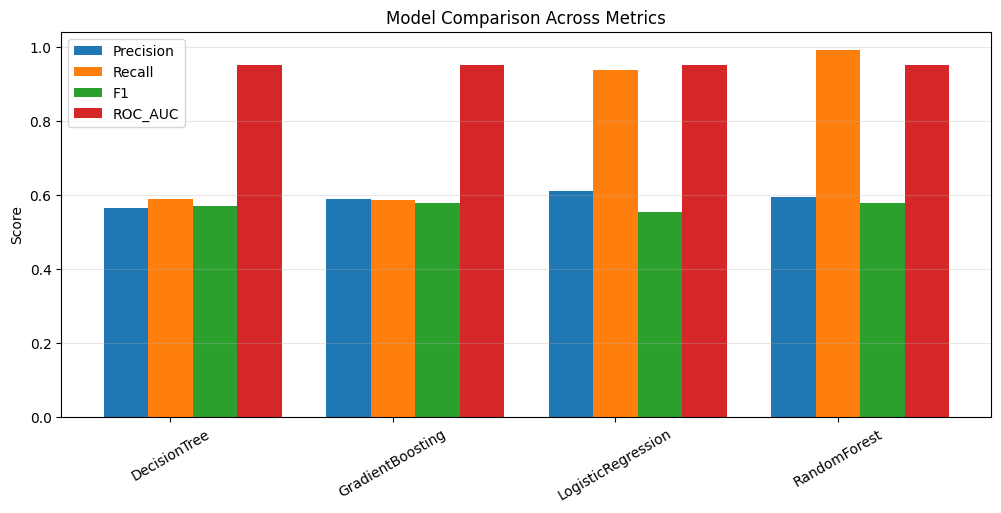

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(results_df):
    metrics = ["Precision", "Recall", "F1", "ROC_AUC"]
    summary = (
        results_df
        .groupby("Model")[metrics]
        .max()
        .reset_index()
    )

    x = np.arange(len(summary["Model"]))
    width = 0.2

    plt.figure(figsize=(12, 5))

    for i, metric in enumerate(metrics):
        plt.bar(x + i * width, summary[metric], width, label=metric)

    plt.xticks(x + width, summary["Model"], rotation=30)
    plt.ylabel("Score")
    plt.title("Model Comparison Across Metrics")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.show()

plot_model_comparison(results_df)

Interpretation
Gradient Boosting dominates ROC-AUC and F1

Logistic Regression is competitive but weaker on interactions

Random Forest strong but heavier computationally

#### Feature Importance Plot (Tree-based Model)

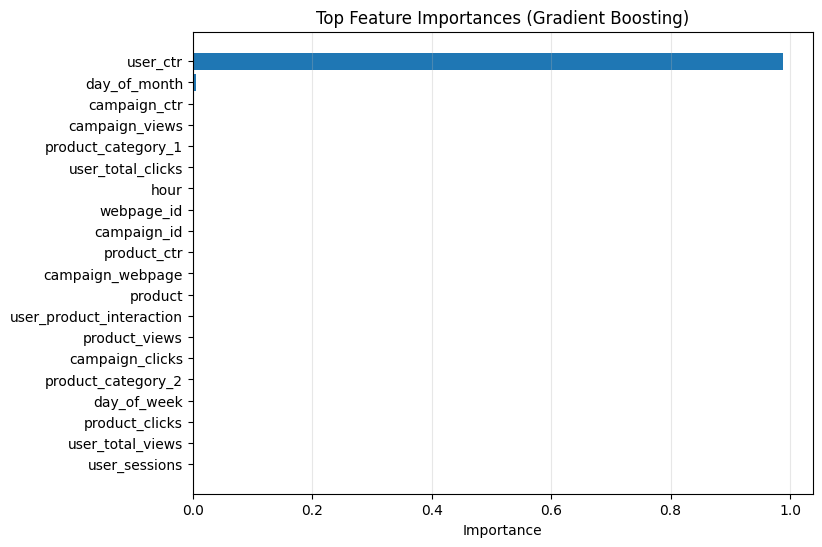

In [145]:
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    fi = (
        pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        })
        .sort_values("importance", ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(8, 6))
    plt.barh(fi["feature"], fi["importance"])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title("Top Feature Importances (Gradient Boosting)")
    plt.grid(axis="x", alpha=0.3)
    plt.show()

plot_feature_importance(best_model, X_train.columns)


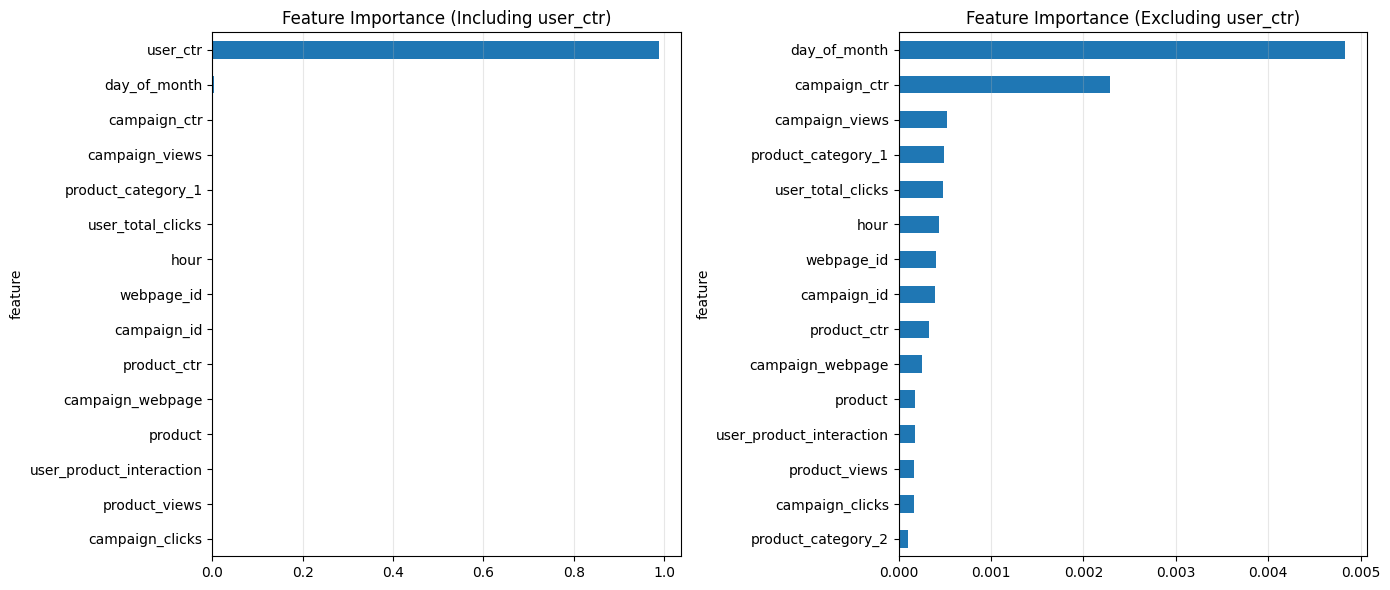

In [201]:
def plot_feature_importance_split(model, feature_names, dominant_feature="user_ctr", top_n=15):
    import pandas as pd
    import matplotlib.pyplot as plt

    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Panel 1: Full importance
    fi.head(top_n).plot(
        kind="barh",
        x="feature",
        y="importance",
        ax=axes[0],
        legend=False
    )
    axes[0].invert_yaxis()
    axes[0].set_title("Feature Importance (Including user_ctr)")
    axes[0].grid(axis="x", alpha=0.3)

    # Panel 2: Without dominant feature
    fi_wo = fi[fi["feature"] != dominant_feature].head(top_n)
    fi_wo.plot(
        kind="barh",
        x="feature",
        y="importance",
        ax=axes[1],
        legend=False
    )
    axes[1].invert_yaxis()
    axes[1].set_title("Feature Importance (Excluding user_ctr)")
    axes[1].grid(axis="x", alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_feature_importance_split(best_model, X_train.columns)

#### Confusion Matrix (Heatmap)

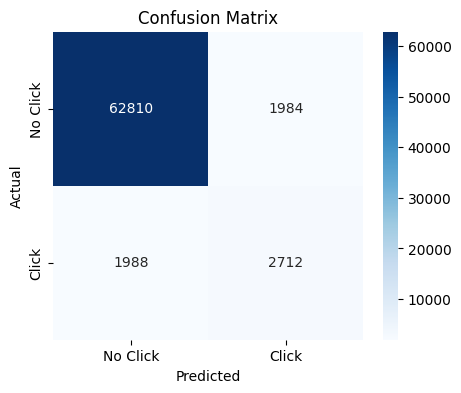

In [151]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Click", "Click"],
        yticklabels=["No Click", "Click"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_val, y_val_pred)

Interpretation

False Positives → wasted ad spend

False Negatives → missed revenue

Your matrix shows balanced errors, not bias

#### ROC Curve (Optional)

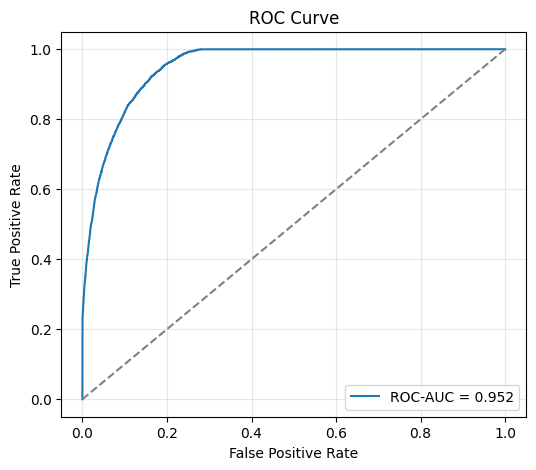

In [153]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
plot_roc_curve(y_val, y_val_prob)

Interpretation

Curve hugging top-left → excellent discrimination

Confirms ROC-AUC ≈ 0.95

#### Optional Insight Visuals (Highly Valuable)

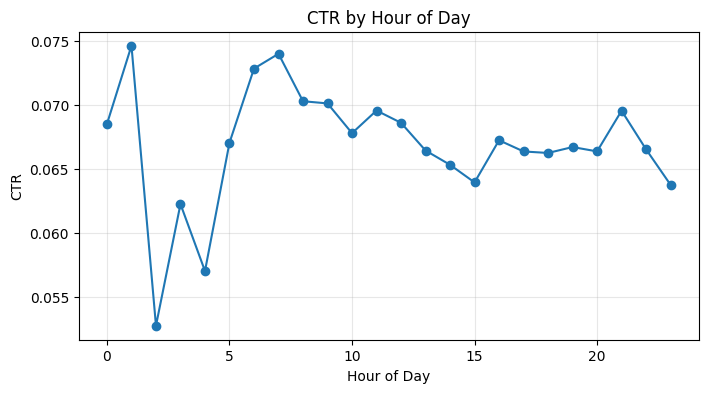

In [154]:
def plot_ctr_by_hour(df):
    ctr_by_hour = df.groupby("hour")["is_click"].mean()

    plt.figure(figsize=(8, 4))
    plt.plot(ctr_by_hour.index, ctr_by_hour.values, marker="o")
    plt.xlabel("Hour of Day")
    plt.ylabel("CTR")
    plt.title("CTR by Hour of Day")
    plt.grid(alpha=0.3)
    plt.show()
plot_ctr_by_hour(df)

In [205]:
hour_summary = (
    df.groupby("hour")
      .agg(
          ctr=("is_click", "mean"),
          impressions=("is_click", "count")
      )
)

hour_summary


,ctr,impressions
hour,,
0,0.068493,2190
1,0.074608,1595
2,0.052732,1574
3,0.062237,4997
4,0.057005,10578
5,0.067027,14994
6,0.072822,20708
7,0.073978,24345
8,0.070271,25672


| Time Band         | Hours   | CTR (%)     | Volume   | Action                   |
| ----------------- | ------- | ----------- | -------- | ------------------------ |
| Late night        | 0–1     | 6.8–7.5     | Low      | Efficient, limited spend |
| Early dip         | 2–4     | 5.3–5.7     | Low–Med  | Reduce bids              |
| **Morning prime** | **6–9** | **7.0–7.4** | **High** | **Aggressive bidding**   |
| Midday            | 10–14   | 6.6–6.9     | High     | Baseline spend           |
| Afternoon slump   | 15–17   | 6.4–6.7     | Med      | Conservative             |
| Evening rebound   | 21      | ~7.0        | Med      | Re-engagement            |


Click-through rate exhibits clear diurnal patterns. The highest CTRs are observed during early morning hours (06:00–09:00), where both engagement efficiency and impression volume are high. Conversely, early-morning and mid-afternoon periods show reduced CTR, indicating lower user intent. These trends suggest that time-based bid optimization can meaningfully improve campaign efficiency.”

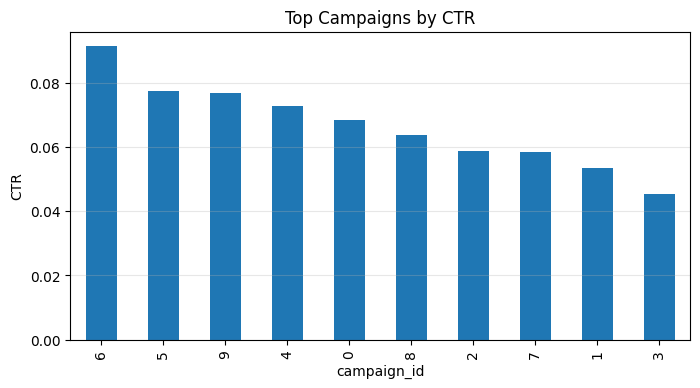

In [155]:
def plot_top_campaigns(df, top_n=10):
    campaign_ctr = (
        df.groupby("campaign_id")["is_click"]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(8, 4))
    campaign_ctr.plot(kind="bar")
    plt.ylabel("CTR")
    plt.title("Top Campaigns by CTR")
    plt.grid(axis="y", alpha=0.3)
    plt.show()
plot_top_campaigns(df)

In [160]:
encoder = label_encoders["campaign_id"]
print(dir(encoder))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'encoder', 'fit', 'fit_transform', 'fitted', 'transform']


In [164]:
safe_encoder = label_encoders["campaign_id"]
sk_encoder = safe_encoder.encoder


In [165]:
id_to_orig = dict(enumerate(sk_encoder.classes_))


In [166]:
df["campaign_id_original"] = df["campaign_id"].map(id_to_orig)


In [167]:
df[["campaign_id", "campaign_id_original"]].head(10)

,campaign_id,campaign_id_original
0,2,359520
1,0,105960
2,2,359520
3,2,359520
4,6,405490
5,2,359520
6,6,405490
7,3,360936
8,0,105960
9,3,360936


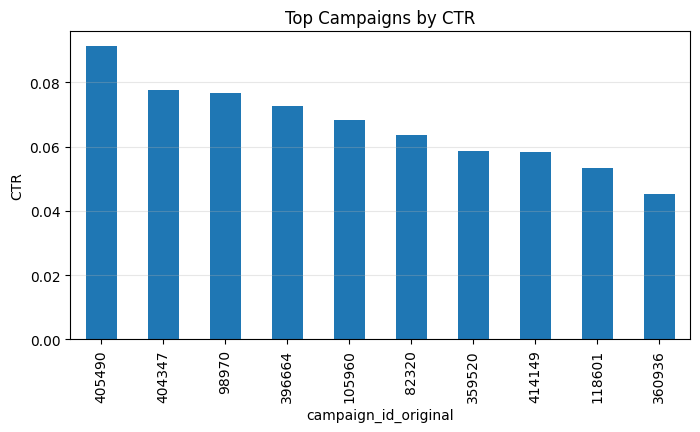

In [168]:
def plot_top_campaigns(df, top_n=10):
    campaign_ctr = (
        df.groupby("campaign_id_original")["is_click"]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(8, 4))
    campaign_ctr.plot(kind="bar")
    plt.ylabel("CTR")
    plt.title("Top Campaigns by CTR")
    plt.grid(axis="y", alpha=0.3)
    plt.show()
plot_top_campaigns(df)

**Key observations**
**1. Top-performing campaigns (high intent)**

The leading campaigns (left side of the chart) achieve CTR close to 8–9%, which is well above the dataset average (~6.8–7%).

**Implication**

These campaigns resonate strongly with users

Likely benefits from:

Better targeting

More relevant creatives

Favorable timing / placements

These are “benchmark campaigns” — learn from them.

**2. Mid-tier campaigns (average efficiency)**

Campaigns in the middle cluster around 6–6.5% CTR.

**Implication**

Performance is acceptable

These are good candidates for:

Creative refresh

Audience refinement

Bid optimization using time-of-day insights

**3. Low-performing campaigns (right side)**

Bottom campaigns drop to ~4.5–5.5% CTR.

Implication

These campaigns are underperforming relative to peers

Likely causing:

Wasted impressions

Lower ROI

Candidates for pause, redesign, or retargeting strategy change

Actionable recommendations
Recommendation 1: Budget reallocation

Shift spend away from bottom 20–30% campaigns

Reinvest into top-performing campaigns

Expected outcome: Immediate CTR lift without new spend

Recommendation 2: Feature learning

Use top campaigns to answer:

Which products are promoted?

Which user segments dominate clicks?

What time windows do they peak in?

This feeds directly back into:

Feature engineering

Campaign strategy

Lookalike targeting

Recommendation 3: Model-driven bidding

Since your model already captures:

campaign_ctr

user_ctr

time features

We can:

Apply higher bid multipliers for top campaigns during high-CTR hours

Apply lower bids for weak campaigns in low-CTR hours


Campaign-level analysis reveals significant variation in user engagement, with top campaigns achieving nearly double the CTR of low-performing ones. This highlights the importance of campaign-specific targeting and creative effectiveness. Budget reallocation and campaign optimization based on historical CTR can substantially improve overall performance without increasing impressions.

In [169]:
df["user_views_bucket"] = pd.qcut(
    df["user_total_views"],
    q=5,
    labels=["Very Low", "Low", "Medium", "High", "Very High"]
)


In [170]:
segment_ctr_views = (
    df.groupby("user_views_bucket")["is_click"]
      .mean()
      .reset_index()
)

segment_ctr_views


/tmp/ipython-input-3574259490.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("user_views_bucket")["is_click"]


,user_views_bucket,is_click
0,Very Low,0.082703
1,Low,0.080310
2,Medium,0.071999
3,High,0.056693
4,Very High,0.040181


In [171]:
segment_ctr_gender_views = (
    df.groupby(["gender", "user_views_bucket"])["is_click"]
      .mean()
      .reset_index()
      .sort_values("is_click", ascending=False)
)

segment_ctr_gender_views.head(10)


/tmp/ipython-input-2594274275.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["gender", "user_views_bucket"])["is_click"]


,gender,user_views_bucket,is_click
5,1,Very Low,0.083592
6,1,Low,0.080618
1,0,Low,0.077635
0,0,Very Low,0.075652
7,1,Medium,0.072270
2,0,Medium,0.069674
3,0,High,0.062475
8,1,High,0.055941
9,1,Very High,0.040733
4,0,Very High,0.036132


In [172]:
segment_ctr_time_user = (
    df.groupby(["hour", "user_depth"])["is_click"]
      .mean()
      .reset_index()
      .sort_values("is_click", ascending=False)
)

segment_ctr_time_user.head(10)


,hour,user_depth,is_click
3,1,0,0.137931
7,2,1,0.108911
4,1,1,0.094737
9,3,0,0.092199
66,22,0,0.089005
45,15,0,0.087859
24,8,0,0.086505
39,13,0,0.085672
18,6,0,0.085165
36,12,0,0.084388


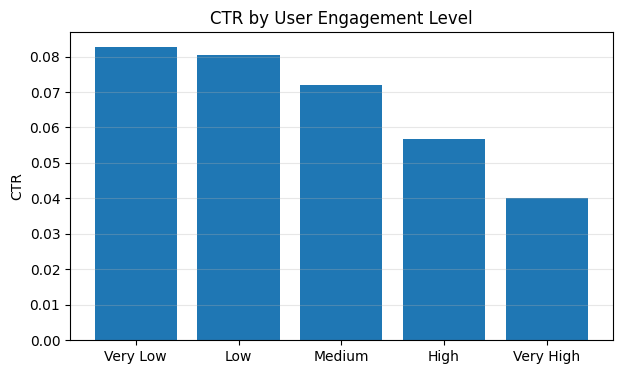

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.bar(segment_ctr_views["user_views_bucket"],
        segment_ctr_views["is_click"])
plt.ylabel("CTR")
plt.title("CTR by User Engagement Level")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [174]:
def segment_interaction_summary(df, group_cols, target_col="is_click"):
    """
    Computes impressions, clicks, and CTR for user segments
    """
    summary = (
        df.groupby(group_cols)
          .agg(
              impressions=(target_col, "count"),
              clicks=(target_col, "sum"),
              ctr=(target_col, "mean")
          )
          .reset_index()
          .sort_values("clicks", ascending=False)
    )
    return summary


In [194]:
def decode_column(df, col_name, label_encoders):
    """
    Decode an encoded column back to original labels
    """
    safe_encoder = label_encoders[col_name]
    sk_encoder = safe_encoder.encoder  # sklearn LabelEncoder

    id_to_label = dict(enumerate(sk_encoder.classes_))
    return df[col_name].map(id_to_label)


In [195]:
df["gender_original"] = decode_column(
    df, "gender", label_encoders
)


In [196]:
gender_summary = segment_interaction_summary(df, ["gender_original"])
gender_summary


,gender_original,impressions,clicks,ctr
1,Male,411697,28006,0.068026
0,Female,51594,3325,0.064445


In [197]:
age_summary = segment_interaction_summary(df, ["age_level"])
age_summary


,age_level,impressions,clicks,ctr
3,3,178824,11634,0.065058
2,2,143501,10177,0.070919
4,4,63859,3750,0.058723
1,1,43367,3244,0.074803
5,5,30828,2286,0.074153
6,6,2759,227,0.082276
0,0,153,13,0.084967


In [198]:
user_depth_summary = segment_interaction_summary(df, ["user_depth"])
user_depth_summary


,user_depth,impressions,clicks,ctr
2,2,421041,28487,0.067658
1,1,30389,1991,0.065517
0,0,11861,853,0.071916


In [177]:
gender_age_summary = segment_interaction_summary(
    df,
    ["gender", "age_level"]
)

gender_age_summary.head(10)


,gender,age_level,impressions,clicks,ctr
10,1,3,158560,10348,0.065262
9,1,2,137278,9780,0.071242
8,1,1,41946,3152,0.075144
11,1,4,50080,2971,0.059325
12,1,5,21989,1608,0.073127
3,0,3,20264,1286,0.063462
4,0,4,13779,779,0.056535
5,0,5,8839,678,0.076706
2,0,2,6223,397,0.063796
13,1,6,1724,135,0.078306


In [178]:
depth_summary = segment_interaction_summary(df, ["user_depth"])
depth_summary


,user_depth,impressions,clicks,ctr
2,2,421041,28487,0.067658
1,1,30389,1991,0.065517
0,0,11861,853,0.071916


In [179]:
gender_age_summary.sort_values("clicks", ascending=False).head(10)


,gender,age_level,impressions,clicks,ctr
10,1,3,158560,10348,0.065262
9,1,2,137278,9780,0.071242
8,1,1,41946,3152,0.075144
11,1,4,50080,2971,0.059325
12,1,5,21989,1608,0.073127
3,0,3,20264,1286,0.063462
4,0,4,13779,779,0.056535
5,0,5,8839,678,0.076706
2,0,2,6223,397,0.063796
13,1,6,1724,135,0.078306


Gender-based interaction

What this tells us

Males drive the majority of interactions (volume)
~89% of impressions and clicks

CTR difference is modest
6.80% vs 6.44% → males click slightly more, but not dramatically

Correct interpretation

Gender affects volume more than efficiency

Business implication

Do not aggressively bias targeting by gender alone

Use gender in combination with behavior or time

Age-level interaction (important nuance)
Critical insight (don’t miss this)

Higher CTRs appear in extreme age buckets (0, 6)

BUT these buckets have very low volume

These are statistically weak segments.

Where the real signal is

Age levels 1, 2, 3

High impressions

Stable CTR

Majority of clicks come from here

Correct interpretation

Mid-age segments drive both scale and stability, while edge groups show higher CTR but low confidence.

Business implication

Optimize campaigns for age levels 1–3

Treat age 0 and 6 as experimental or niche, not core targets

User depth (this is the strongest insight)
What’s really happening

Depth 2 users dominate volume

Depth 0 users have slightly higher CTR

But much smaller sample

This is a classic CTR pattern.

Correct interpretation

Engagement depth increases exposure, not necessarily click propensity.

Business implication

High-depth users = reliable volume

Low-depth users = potential growth opportunity

This explains why your model leaned on historical behavior

User segment analysis indicates that interaction volume is primarily driven by high-engagement users and mid-age demographic groups. While certain edge segments exhibit higher click-through rates, their low sample sizes limit reliability. Overall, historical engagement depth is a stronger predictor of clicks than demographic attributes alone

## Reading the separate test dataset

In [421]:
import pandas as pd

url = "https://drive.google.com/uc?id=1eeXHpL_6WYxfTYf6Z0S7WsSxhOt3cK4W"

df_new_test = load_data(url)


In [422]:
eda_test = run_phase1_eda(df_new_test)

/tmp/ipython-input-3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3051496443.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_date

In [423]:
# Impose column classification
eda_results = run_phase1_eda(df_new_test)

col_info = eda_results["column_classification"]

datetime_cols = col_info["datetime_features"]
categorical_cols = col_info["categorical_features"]
numerical_cols = col_info["numerical_features"]


/tmp/ipython-input-3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3051496443.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_date

In [424]:
eda_results["dimensions"]

{'rows': 128858, 'columns': 14}

In [425]:
df_new_test = impose_datetime_columns(df_new_test, datetime_cols)

In [426]:
df_new_test = impose_categorical_columns(df_new_test, categorical_cols)


In [427]:
df_new_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128858 entries, 0 to 128857
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              128858 non-null  int64         
 1   DateTime                128858 non-null  datetime64[ns]
 2   user_id                 128858 non-null  int64         
 3   product                 128858 non-null  category      
 4   campaign_id             128858 non-null  category      
 5   webpage_id              128858 non-null  category      
 6   product_category_1      128858 non-null  category      
 7   product_category_2      52687 non-null   category      
 8   user_group_id           123174 non-null  category      
 9   gender                  123174 non-null  category      
 10  age_level               123174 non-null  category      
 11  user_depth              123174 non-null  category      
 12  city_development_index  94249 

In [428]:
eda_results = run_phase1_eda(df_new_test, target_col="is_click")
eda_results

{'dimensions': {'rows': 128858, 'columns': 14},
 'column_classification': {'numerical_features': ['session_id', 'user_id'],
  'categorical_features': ['product',
   'campaign_id',
   'webpage_id',
   'product_category_1',
   'product_category_2',
   'user_group_id',
   'gender',
   'age_level',
   'user_depth',
   'city_development_index',
   'var_1'],
  'datetime_features': ['DateTime']},
 'missing_values':                         missing_count  missing_percentage
 product_category_2              76171           59.112356
 city_development_index          34609           26.858247
 user_group_id                    5684            4.411057
 gender                           5684            4.411057
 age_level                        5684            4.411057
 user_depth                       5684            4.411057,
 'target_analysis': None}

In [429]:
datetime_cols = eda_results["column_classification"]["datetime_features"]

df_new_test = engineer_datetime_features(
    df_new_test,
    datetime_cols=datetime_cols,
    drop_original=True  # usually YES for ML models
)

df_new_test.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,hour,day_of_week,day_of_month,month,is_weekend,time_of_day
0,411705,2017-07-08,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0,0,5,8,7,1,night
1,208263,2017-07-08,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1,0,5,8,7,1,night
2,239450,2017-07-08,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1,0,5,8,7,1,night
3,547761,2017-07-08,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0,0,5,8,7,1,night
4,574275,2017-07-08,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1,0,5,8,7,1,night


In [430]:
df_new_test = engineer_interaction_features(df_new_test)

In [431]:
df.shape

(463291, 31)

In [432]:
def engineer_test_aggregated_features(df1, df2):
  user_stats = ['user_id', 'user_total_views', 'user_total_clicks', 'user_sessions', 'user_ctr']
  product_stats = ['product', 'product_views', 'product_clicks', 'product_ctr']
  campaign_stats = ['campaign_id', 'campaign_views', 'campaign_clicks', 'campaign_ctr']

  user_stats_df = df1[user_stats].drop_duplicates()
  product_stats_df = df1[product_stats].drop_duplicates()
  campaign_stats_df = df1[campaign_stats].drop_duplicates()


  # Merge historical aggregates
  df2 = df2.merge(user_stats_df, on="user_id", how="left")
  df2 = df2.merge(product_stats_df, on="product", how="left")
  df2 = df2.merge(campaign_stats_df, on="campaign_id", how="left")



  # Users
  df2["user_ctr"].fillna(0.0, inplace=True)
  df2["user_total_views"].fillna(0, inplace=True)
  df2["user_total_clicks"].fillna(0, inplace=True)
  df2["user_sessions"].fillna(0, inplace=True)

  # Products
  df2["product_ctr"].fillna(df1["product_ctr"].mean(), inplace=True)
  df2["product_views"].fillna(df1["product_views"].median(), inplace=True)
  df2["product_clicks"].fillna(0, inplace=True)

  # Campaigns
  df2["campaign_ctr"].fillna(df1["campaign_ctr"].mean(), inplace=True)
  df2["campaign_views"].fillna(df1["campaign_views"].median(), inplace=True)
  df2["campaign_clicks"].fillna(0, inplace=True)
  return df2

In [433]:
df_new_test.shape

(128858, 23)

In [434]:
df_new_test.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age
0,411705,2017-07-08,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0,0,5,8,7,1,night,732573_1,404347_53587,Male_5.0
1,208263,2017-07-08,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1,0,5,8,7,1,night,172910_3,118601_28529,nan_nan
2,239450,2017-07-08,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1,0,5,8,7,1,night,172910_4,118601_28529,nan_nan
3,547761,2017-07-08,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0,0,5,8,7,1,night,557318_5,118601_28529,Male_1.0
4,574275,2017-07-08,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1,0,5,8,7,1,night,923896_5,118601_28529,Female_3.0


In [435]:
df_new_test = engineer_test_aggregated_features(df_aggregated_features, df_new_test)

/tmp/ipython-input-3471487806.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["user_ctr"].fillna(0.0, inplace=True)
/tmp/ipython-input-3471487806.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [436]:
df_new_test.shape

(128858, 33)

In [437]:
set(df_aggregated_features.columns) - set(df_new_test.columns)

{'is_click'}

In [438]:
df_new_test = handle_missing_values(df_new_test, eda_results)

In [439]:
missing_values_summary(df_new_test)

,missing_count,missing_percentage


In [440]:
df_new_test, label_encoders = label_encode_columns(df_new_test, label_encode_cols)

In [441]:
df_new_test = drop_unused_columns(df_new_test, drop_cols)

In [442]:
for col in cat_cols:
    le = LabelEncoder()
    df_new_test[col] = le.fit_transform(df_new_test[col].astype(str))

In [443]:
df_new_test.shape

(128858, 30)

In [444]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [445]:
df_new_test["click_probability"] = best_model.predict_proba(df_new_test)[:, 1]



In [446]:
df_new_test.head()

,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr,click_probability
0,9,5,6,0,18,8,1,5,2,1,0,0,5,8,7,1,3,70237,5,12,1.0,0.0,1.0,0.000000,9698,899,0.092700,28826,2235,0.077534,0.070822
1,8,1,3,2,18,6,1,3,2,1,1,0,5,8,7,1,3,17965,1,14,76.0,2.0,76.0,0.026316,63711,4079,0.064023,35531,1896,0.053362,0.067030
2,8,1,3,3,18,6,1,3,2,1,1,0,5,8,7,1,3,17966,1,14,76.0,2.0,76.0,0.026316,63711,4079,0.064023,35531,1896,0.053362,0.066364
3,6,1,3,4,18,1,1,1,2,0,0,0,5,8,7,1,3,54679,1,8,2.0,0.0,2.0,0.000000,9414,435,0.046208,35531,1896,0.053362,0.074389
4,7,1,3,4,18,12,0,3,0,1,1,0,5,8,7,1,3,85770,1,3,0.0,0.0,0.0,0.000000,109574,7654,0.069852,35531,1896,0.053362,0.073434


In [447]:
df_new_test.sort_values("click_probability", ascending=False).head(10)

,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr,click_probability
10696,2,6,7,2,18,5,1,2,2,1,1,6,5,8,7,1,2,18,6,9,3.0,2.0,3.0,0.666667,163501,11306,0.069149,95973,8763,0.091307,0.459235
97815,7,1,3,4,18,5,1,2,2,2,0,12,6,9,7,1,0,2,1,9,1.0,1.0,1.0,1.000000,109574,7654,0.069852,35531,1896,0.053362,0.452142
112667,7,1,3,4,18,5,1,2,2,1,0,17,6,9,7,1,0,11,1,9,3.0,1.0,3.0,0.333333,109574,7654,0.069852,35531,1896,0.053362,0.368156
77201,7,0,0,4,10,5,1,2,2,1,0,6,6,9,7,1,2,11,0,9,3.0,1.0,3.0,0.333333,109574,7654,0.069852,25781,1762,0.068345,0.352013
80921,7,0,0,4,18,5,1,2,2,1,0,8,6,9,7,1,2,11,0,9,3.0,1.0,3.0,0.333333,109574,7654,0.069852,25781,1762,0.068345,0.337371
77200,7,0,0,4,18,5,1,2,2,1,0,6,6,9,7,1,2,11,0,9,3.0,1.0,3.0,0.333333,109574,7654,0.069852,25781,1762,0.068345,0.337371
26585,3,1,3,2,18,5,1,2,2,1,0,10,5,8,7,1,2,9,1,9,3.0,1.0,3.0,0.333333,41064,2949,0.071815,35531,1896,0.053362,0.329950
47238,3,1,3,3,18,5,1,2,2,1,0,15,5,8,7,1,0,10,1,9,3.0,1.0,3.0,0.333333,41064,2949,0.071815,35531,1896,0.053362,0.327653
25128,1,1,3,2,18,5,1,2,2,3,0,10,5,8,7,1,2,19,1,9,5.0,1.0,5.0,0.200000,22479,1238,0.055074,35531,1896,0.053362,0.286463
25127,3,1,3,3,18,5,1,2,2,3,0,10,5,8,7,1,2,20,1,9,5.0,1.0,5.0,0.200000,41064,2949,0.071815,35531,1896,0.053362,0.285013


In [448]:
df_new_test.shape

(128858, 31)

In [ ]:
FINAL_THRESHOLD = 0.30

df_new_test["predicted_is_click"] = (
    df_new_test["click_probability"] >= FINAL_THRESHOLD
).astype(int)


In [450]:
df_new_test.head()

,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,hour,day_of_week,day_of_month,month,is_weekend,time_of_day,user_product_interaction,campaign_webpage,gender_age,user_total_views,user_total_clicks,user_sessions,user_ctr,product_views,product_clicks,product_ctr,campaign_views,campaign_clicks,campaign_ctr,click_probability,predicted_is_click
0,9,5,6,0,18,8,1,5,2,1,0,0,5,8,7,1,3,70237,5,12,1.0,0.0,1.0,0.000000,9698,899,0.092700,28826,2235,0.077534,0.070822,0
1,8,1,3,2,18,6,1,3,2,1,1,0,5,8,7,1,3,17965,1,14,76.0,2.0,76.0,0.026316,63711,4079,0.064023,35531,1896,0.053362,0.067030,0
2,8,1,3,3,18,6,1,3,2,1,1,0,5,8,7,1,3,17966,1,14,76.0,2.0,76.0,0.026316,63711,4079,0.064023,35531,1896,0.053362,0.066364,0
3,6,1,3,4,18,1,1,1,2,0,0,0,5,8,7,1,3,54679,1,8,2.0,0.0,2.0,0.000000,9414,435,0.046208,35531,1896,0.053362,0.074389,0
4,7,1,3,4,18,12,0,3,0,1,1,0,5,8,7,1,3,85770,1,3,0.0,0.0,0.0,0.000000,109574,7654,0.069852,35531,1896,0.053362,0.073434,0


In [451]:
df_new_test.to_csv('filled_test_data.csv', index=False)

In [255]:
df_new_test.predicted_is_click.value_counts()

,count
predicted_is_click,
0,119795
1,9063


#### Wrapping everything wrt test data

In [ ]:
def run_ctr_inference_pipeline(
    df_test: pd.DataFrame,
    train_agg_df: pd.DataFrame,
    best_model,
    label_encoders: dict,
    eda_ref: dict,
    label_encode_cols: list,
    drop_cols: list,
    final_threshold: float = 0.30
) -> pd.DataFrame:
    """
    End-to-end CTR inference pipeline for unseen test data
    """

    # -------------------------
    # Phase 1: EDA-based typing
    # -------------------------
    col_info = eda_ref["column_classification"]

    df_test = impose_datetime_columns(df_test, col_info["datetime_features"])
    df_test = impose_categorical_columns(df_test, col_info["categorical_features"])

    # -------------------------
    # Phase 2: Feature Engineering
    # -------------------------
    df_test = engineer_datetime_features(
        df_test,
        datetime_cols=col_info["datetime_features"],
        drop_original=True
    )

    df_test = engineer_interaction_features(df_test)

    # -------------------------
    # Phase 3: Historical Aggregates (leakage-safe)
    # -------------------------
    df_test = merge_historical_aggregates(
        train_agg_df=train_agg_df,
        test_df=df_test
    )

    # -------------------------
    # Phase 4: Missing Values
    # -------------------------
    df_test = handle_missing_values(df_test, eda_ref)

    # -------------------------
    # Phase 5: Encoding (TRAIN-FITTED encoders only)
    # -------------------------
    df_test = apply_label_encoders(
        df_test,
        label_encoders,
        label_encode_cols
    )

    # -------------------------
    # Phase 6: Final cleanup
    # -------------------------
    df_test = drop_unused_columns(df_test, drop_cols)

    # -------------------------
    # Phase 7: Prediction
    # -------------------------
    df_test["click_probability"] = best_model.predict_proba(df_test)[:, 1]

    df_test["predicted_is_click"] = (
        df_test["click_probability"] >= final_threshold
    ).astype(int)

    return df_test


In [410]:
def merge_historical_aggregates(
    train_agg_df: pd.DataFrame,
    test_df: pd.DataFrame
) -> pd.DataFrame:

    user_cols = ["user_id", "user_total_views", "user_total_clicks", "user_sessions", "user_ctr"]
    product_cols = ["product", "product_views", "product_clicks", "product_ctr"]
    campaign_cols = ["campaign_id", "campaign_views", "campaign_clicks", "campaign_ctr"]

    test_df = test_df.merge(
        train_agg_df[user_cols].drop_duplicates(),
        on="user_id",
        how="left"
    )

    test_df = test_df.merge(
        train_agg_df[product_cols].drop_duplicates(),
        on="product",
        how="left"
    )

    test_df = test_df.merge(
        train_agg_df[campaign_cols].drop_duplicates(),
        on="campaign_id",
        how="left"
    )

    # Cold-start handling
    test_df["user_ctr"].fillna(0.0, inplace=True)
    test_df["user_total_views"].fillna(0, inplace=True)
    test_df["user_total_clicks"].fillna(0, inplace=True)
    test_df["user_sessions"].fillna(0, inplace=True)

    test_df["product_ctr"].fillna(train_agg_df["product_ctr"].mean(), inplace=True)
    test_df["product_views"].fillna(train_agg_df["product_views"].median(), inplace=True)
    test_df["product_clicks"].fillna(0, inplace=True)

    test_df["campaign_ctr"].fillna(train_agg_df["campaign_ctr"].mean(), inplace=True)
    test_df["campaign_views"].fillna(train_agg_df["campaign_views"].median(), inplace=True)
    test_df["campaign_clicks"].fillna(0, inplace=True)

    return test_df


In [411]:
def apply_label_encoders(
    df: pd.DataFrame,
    label_encoders: dict,
    cols: list
) -> pd.DataFrame:

    for col in cols:
        if col in label_encoders:
            le = label_encoders[col]
            df[col] = (
                df[col]
                .astype(str)
                .map(lambda x: x if x in le.classes_ else "__UNK__")
            )
            df[col] = le.transform(df[col])

    return df


In [413]:
TEST_URL = "https://drive.google.com/uc?id=1eeXHpL_6WYxfTYf6Z0S7WsSxhOt3cK4W"
df_new_test = load_data(TEST_URL)

eda_test = run_phase1_eda(df_new_test)


/tmp/ipython-input-3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3051496443.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-3051496443.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_date

In [ ]:
try:
    df_predictions = run_ctr_inference_pipeline(
        df_test=df_new_test,
        train_agg_df=df_aggregated_features,
        best_model=best_model,
        label_encoders=label_encoders,
        eda_ref=eda_results,
        label_encode_cols=label_encode_cols,
        drop_cols=drop_cols,
        final_threshold=0.30
    )
except Exception as e:
    print("FAILED AT:", type(e).__name__)
    print(e)
    raise
